## Imports

In [7]:
import pandas as pd
import re
import timeit
import lightgbm as lgb
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import IsolationForest
import plotly.express as px
import numpy as np
import warnings
import datetime
import xgboost as xgb
import math
import joblib
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
import tsaug
from tsaug.visualization import plot

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
set_visualize_provider(InlineProvider())

warnings.filterwarnings("ignore")

#Imports TFG Original
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression



## Funció Alineament de Dades

In [3]:
def alignSeries(serie, lag):
    minutesRow = 30
    posToMove = int(lag / minutesRow)  
    outputSerie = serie['data'].to_numpy()
    size = len(outputSerie)
    outputSerie = np.pad(outputSerie, (posToMove,0), 'constant', constant_values=(0))
    outputSerie = outputSerie[:size]
    return outputSerie

## Carregar Dades

In [3]:
def prepareDFMod(df, col):
    output = df[[col]]
    output.rename(columns={col:'data'}, inplace=True)
    return output
    

In [4]:
# Carregar dades pluja
def loadDataPrecipitacions():
    precipitacions = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
    return precipitacions

In [5]:
# Carregar dades Alt Ter
def loadDataTer(nom, Ter):
    
    altTer = prepareDFMod(Ter, nom)
    
    return altTer

In [6]:
#Carregar dades precipitacions Alt Ter:
def loadDataPrecipitacions(nom, precipitacions):
    
    #Carregar dades
    precipitacions = prepareDFMod(precipitacions, nom)
    
    #Moving Average
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    
    return precipitacions

In [7]:
altTer = pd.read_excel("Dataframes/df_imputedAltTerKNN.xlsx", index_col=0)
baixTer = pd.read_excel("Dataframes/df_imputedBaixTerKNN.xlsx", index_col=0)
precipitacions = pd.read_csv("finalsDF/DF_SMC.csv", index_col=0)

# Alineament del DataFrame amb Referencia (Alt Ter)

In [18]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [19]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [20]:
#Carregar Dades Comparatives

#Alinear Ripoll
ripoll = loadDataTer("L17147-72-00005", altTer)
ripoll = alignSeries(ripoll, 150)

#Alinear Sant Joan
santJoan = loadDataTer("L17167-72-00001", altTer)
santJoan = alignSeries(santJoan, 180)

#Alinear DG
DG = loadDataPrecipitacions("DG", precipitacions)
DG = alignSeries(DG, 270)

#Alinear CG 
CG = loadDataPrecipitacions("CG", precipitacions)
CG = alignSeries(CG, 300)

#Alinear CI
CI = loadDataPrecipitacions("CI", precipitacions)
CI = alignSeries(CI, 150)

#Alinear V4
V4 = loadDataPrecipitacions("V4", precipitacions)
V4 = alignSeries(V4, 180)

#Alinear CC
CC = loadDataPrecipitacions("CC", precipitacions)
CC = alignSeries(CC, 195)

#Alinear CY
CY = loadDataPrecipitacions("CY", precipitacions)
CY = alignSeries(CY, 240)

#Alinear VN
VN = loadDataPrecipitacions("VN", precipitacions)
VN = alignSeries(VN, 300)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 300)

#Alinear V3

V3 = loadDataPrecipitacions("V3", precipitacions)
V3 = alignSeries(V3, 210)

#Z4_ZC

C:\Users\34605\AppData\Local\Temp\ipykernel_11332\3913179418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output.rename(columns={col:'data'}, inplace=True)


NameError: name 'alignSeries' is not defined

In [13]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfAltX = pd.DataFrame(index=range(len(idx)))
dfAltX["L17147-72-00005"] = pd.Series(ripoll.tolist())
dfAltX["L17167-72-00001"] = pd.Series(santJoan.tolist())
dfAltX['DG'] = pd.Series(DG.tolist())
dfAltX['CG'] = pd.Series(CG.tolist())
dfAltX['CI'] = pd.Series(CI.tolist())
dfAltX['V4'] = pd.Series(V4.tolist())
dfAltX['CC'] = pd.Series(CC.tolist())
dfAltX['CY'] = pd.Series(CY.tolist())
dfAltX['VN'] = pd.Series(VN.tolist())
dfAltX['WS'] = pd.Series(WS.tolist())
dfAltX['V3'] = pd.Series(V3.tolist())



In [14]:
#Assignem les hores al index
dfAltX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfAltX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfAltX.drop(dfAltX.head(posToMove).index, inplace=True)
dfAltX.drop(dfAltX.tail(1).index, inplace=True)
dfAltX.fillna(0, inplace=True)


In [15]:
#Eliminem les mateixes columnes del 
masies = loadDataTer("L08116-72-00002", altTer)
masies.rename(columns={'data':'L08116-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
masies.drop(masies.head(posToMove).index, inplace=True)
dfAltY = masies
dfAltX.fillna(0, inplace=True)
dfAltY.fillna(0, inplace=True)

In [16]:
#Guardem el matrix de X y el array de y en un csv

dfAltX.to_csv('dfAltX.csv')
dfAltY.to_csv('dfAltY.csv')

# Alineament del DataFrame amb Referencia (Baix Ter)

In [11]:
idx = pd.date_range("2009-01-01", periods=210386, freq="30T")

In [12]:
ts = pd.Series(range(len(idx)), index=range(len(idx)))

In [13]:
#Carregar Dades Comparatives

#Alinear L17199-72-00001

L171997200001 = loadDataTer("L17199-72-00001", baixTer)
L171997200001 = alignSeries(L171997200001, 300)

#Alinear F026458

F026458 = loadDataTer("F026458", baixTer)
F026458 = alignSeries(F026458, 300)

#Alinear F001242
F001242 = loadDataTer("F001242", baixTer)
F001242 = alignSeries(F001242, 300)

#Alinear L170797200005
L170797200005 = loadDataTer("L17079-72-00005", baixTer)
L170797200005 = alignSeries(L170797200005, 270)

#Alinear L17079-72-00004

L170797200004 = loadDataTer("L17079-72-00004", baixTer)
L170797200004 = alignSeries(L170797200004, 270)

#Alinear L17038-72-00002

L170387200002 = loadDataPrecipitacions("L17038-72-00002", baixTer)
L170387200002 = alignSeries(L170387200002, 270)

#Alinear KE
KE = loadDataPrecipitacions("KE", precipitacions)
KE = alignSeries(KE, 300)

#Alinear UO
UO = loadDataPrecipitacions("UO", precipitacions)
UO = alignSeries(UO, 480)

#Alinear UN
UN = loadDataPrecipitacions("UN", precipitacions)
UN = alignSeries(UN, 405)

#Alinear WS
WS = loadDataPrecipitacions("WS", precipitacions)
WS = alignSeries(WS, 270)

#Alinear DJ

DJ = loadDataPrecipitacions("DJ", precipitacions)
DJ = alignSeries(DJ, 360)



NameError: name 'prepareDFMod' is not defined

In [19]:
#Creem el DataFrame amb les dades alineades i el guardem 
dfBaixX = pd.DataFrame(index=range(len(idx)))
dfBaixX["L17199-72-00001"] = pd.Series(L171997200001.tolist())
dfBaixX["F026458"] = pd.Series(F026458.tolist())
dfBaixX['F001242'] = pd.Series(F001242.tolist())
dfBaixX['L17079-72-00005'] = pd.Series(L170797200005.tolist())
dfBaixX['L17079-72-00004'] = pd.Series(L170797200004.tolist())
dfBaixX['L17038-72-00002'] = pd.Series(L170387200002.tolist())
dfBaixX['KE'] = pd.Series(KE.tolist())
dfBaixX['UO'] = pd.Series(UO.tolist())
dfBaixX['UN'] = pd.Series(UN.tolist())
dfBaixX['WS'] = pd.Series(WS.tolist())
dfBaixX['DJ'] = pd.Series(DJ.tolist())




In [20]:
#Assignem les hores al index
dfBaixX['datetime'] = pd.date_range("2009-01-01", periods=210386, freq="30T")
dfBaixX.set_index('datetime', drop=True, inplace=True)

#Eliminem del top el maxim de posicions que hem alineat (en aquest cas 300)

minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
dfBaixX.drop(dfBaixX.head(posToMove).index, inplace=True)
dfBaixX.drop(dfBaixX.tail(1).index, inplace=True)
dfBaixX.fillna(0, inplace=True)

In [21]:
#Eliminem les mateixes columnes del 
colomers = loadDataTer("L17055-72-00002", baixTer)
colomers.rename(columns={'data':'L17055-72-00002'}, inplace=True)
minutesRow = 30
lag = 300
posToMove = int(lag / minutesRow)
colomers.drop(colomers.head(posToMove).index, inplace=True)
dfBaixY = colomers
dfBaixX.fillna(0, inplace=True)
dfBaixY.fillna(0, inplace=True)

In [22]:
#Guardem el matrix de X y el array de y en un csv

dfBaixX.to_csv('dfBaixX.csv')
dfBaixY.to_csv('dfBaixY.csv')

# Pre-processament de Dades (Data Augmentation, Splits, etc...)

## Train Only Events

In [12]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [13]:
def calcularAnomalyFitted(df, col, cont=0.3):
    #Crear una versio horaria del dataset
    
    df['timestamp'] = pd.to_datetime(df["DATA"])
    df = df.set_index('timestamp').resample("30T").mean().reset_index()
    
    #Usem el metode de Isolation Forest per trobar anomalies a les precipitacions
    output = df[[col, 'timestamp']]
    temp = df[[col, 'timestamp']]
    model=IsolationForest(n_estimators=50, max_samples='auto', contamination=cont,max_features=1.0)
    model.fit(temp[[col]].values)
    output['outliers']=pd.Series(model.predict(temp[[col]].values)).apply(lambda x: 'yes' if (x == -1) else 'no' )
    
    return output

anomaliesAlt = calcularAnomalyFitted(Df_Alty, 'L08116-72-00002')
anomaliesBaix = calcularAnomalyFitted(Df_Baixy, 'L17055-72-00002')


In [14]:
anomaliesAltY = anomaliesAlt.loc[anomaliesAlt['outliers'] == 'yes']
anomaliesAltY.drop(columns=['outliers'],inplace=True)
anomaliesAltX = Df_AltX.loc[np.intersect1d(anomaliesAltY.index, Df_AltX.index)]
anomaliesAltY = anomaliesAltY.set_index('timestamp')
anomaliesAltX = anomaliesAltX.set_index('datetime')


In [15]:
anomaliesBaixY = anomaliesBaix.loc[anomaliesBaix['outliers'] == 'yes']
anomaliesBaixY.drop(columns=['outliers'],inplace=True)
anomaliesBaixX = Df_BaixX.loc[np.intersect1d(anomaliesBaixY.index, Df_BaixX.index)]
anomaliesBaixY = anomaliesBaixY.set_index('timestamp')
anomaliesBaixX = anomaliesBaixX.set_index('datetime')

In [16]:
anomaliesAltX.to_csv('dfAltXAnomalies.csv')
anomaliesAltY.to_csv('dfAltYAnomalies.csv')
anomaliesBaixX.to_csv('dfBaixXAnomalies.csv')
anomaliesBaixY.to_csv('dfBaixYAnomalies.csv')

## Data Augmentation (Adding Noise)

In [2]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')
Df_BaixX = pd.read_csv('dfBaixX.csv')
Df_Baixy = pd.read_csv('dfBaixY.csv')

In [3]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_BaixX.set_index('datetime', drop=True, inplace=True)

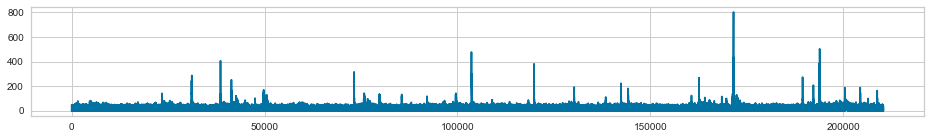

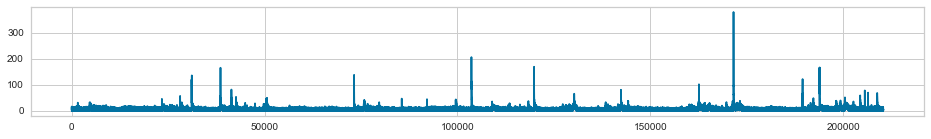

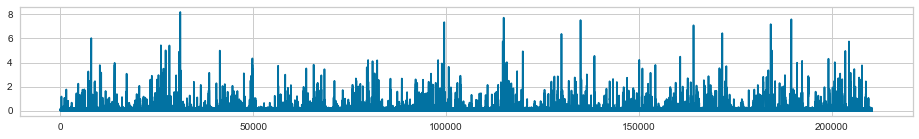

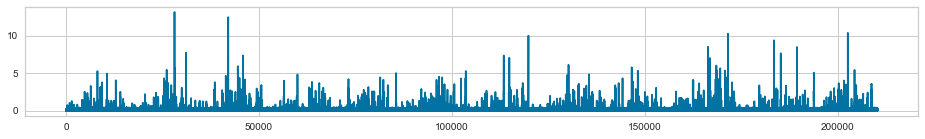

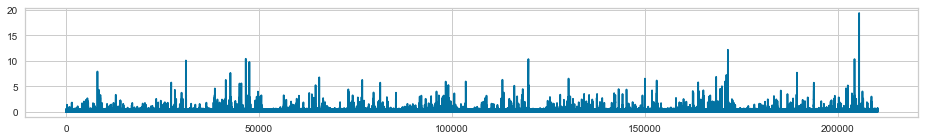

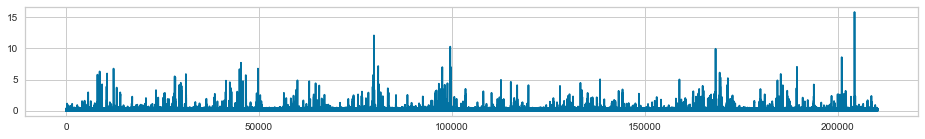

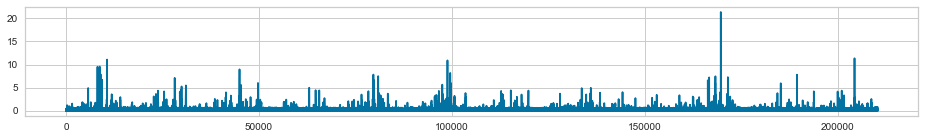

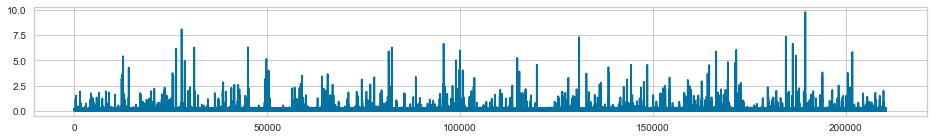

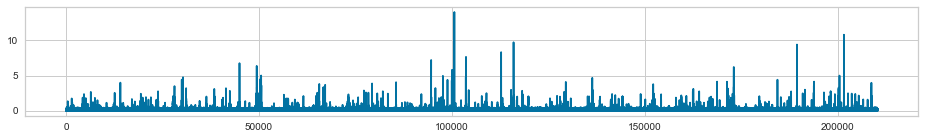

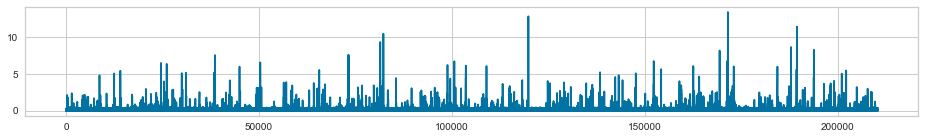

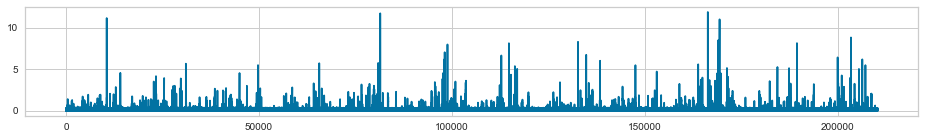

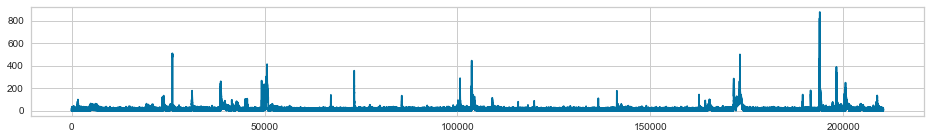

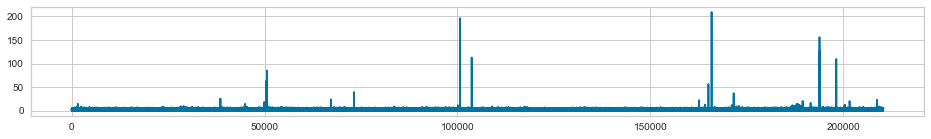

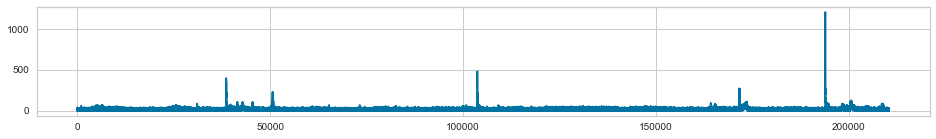

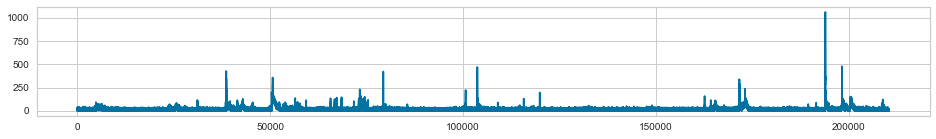

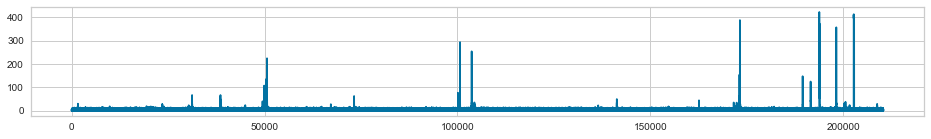

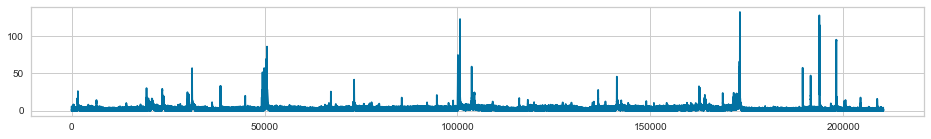

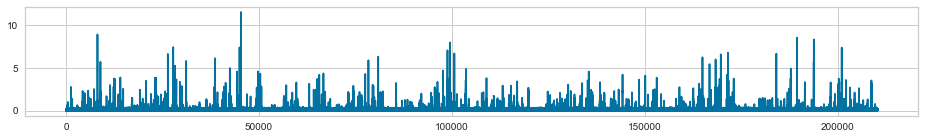

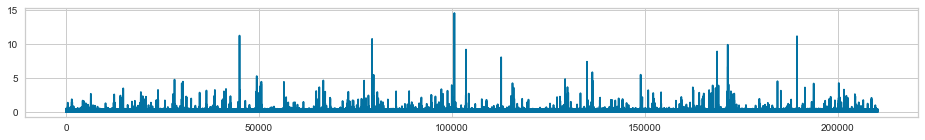

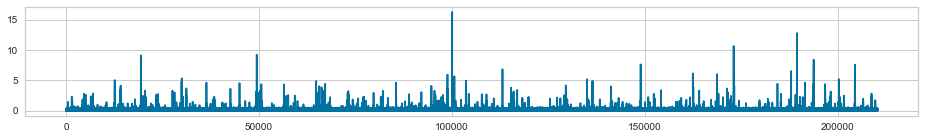

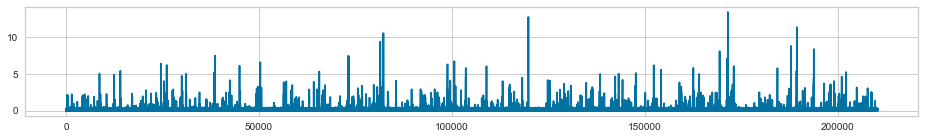

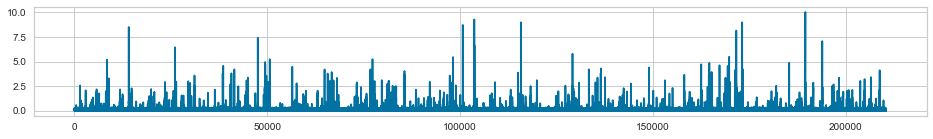

In [8]:
def addNoiseTimeSeries(df, scale=0.01):
    for column in df:
        array = df[column].to_numpy()
        aug = abs(tsaug.AddNoise(scale=scale).augment(array))
        df[column] = aug
        plot(aug)

addNoiseTimeSeries(Df_AltX)
addNoiseTimeSeries(Df_BaixX)


In [11]:
Df_AltX.to_csv('dfAltXNoise.csv')
Df_BaixX.to_csv('dfBaixXNoise.csv')

# Seleccionar DataSet

In [17]:
def datasetAlignNormal():
    Df_AltX = pd.read_csv('dfAltX.csv')
    Df_Alty = pd.read_csv('dfAltY.csv')
    Df_BaixX = pd.read_csv('dfBaixX.csv')
    Df_Baixy = pd.read_csv('dfBaixY.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignAnomalies():
    Df_AltX = pd.read_csv('dfAltXAnomalies.csv')
    Df_Alty = pd.read_csv('dfAltYAnomalies.csv')
    Df_BaixX = pd.read_csv('dfBaixXAnomalies.csv')
    Df_Baixy = pd.read_csv('dfBaixYAnomalies.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy

def datasetAlignNoise():
    Df_AltX = pd.read_csv('dfAltXNoise.csv')
    Df_Alty = pd.read_csv('dfAltY.csv')
    Df_BaixX = pd.read_csv('dfBaixXNoise.csv')
    Df_Baixy = pd.read_csv('dfBaixY.csv')
    Df_AltX.set_index('datetime', drop=True, inplace=True)
    Df_Alty.set_index('DATA', drop=True, inplace=True)
    Df_BaixX.set_index('datetime', drop=True, inplace=True)
    Df_Baixy.set_index('DATA', drop=True, inplace=True)
    
    return Df_AltX, Df_Alty, Df_BaixX, Df_Baixy



In [48]:
Df_AltX, Df_Alty, Df_BaixX, Df_Baixy = datasetAlignNoise()

# Models Alt Ter

# Random Forest (Alt Ter)

In [49]:
df_results_altTer = pd.DataFrame(columns = ["Method","Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 19.4 s
Wall time: 1min 5s


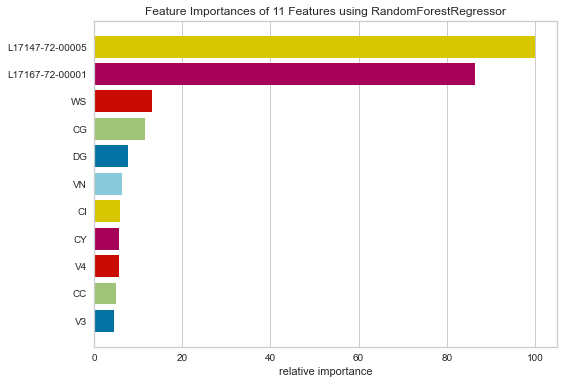

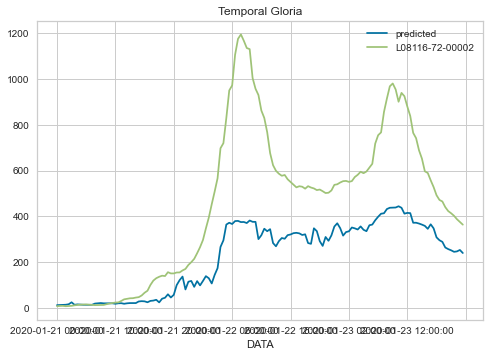

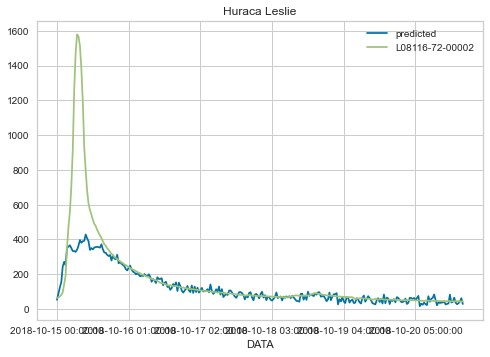

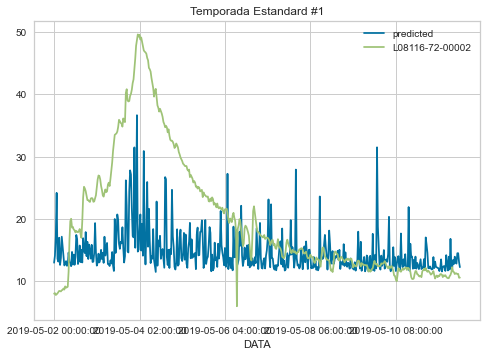

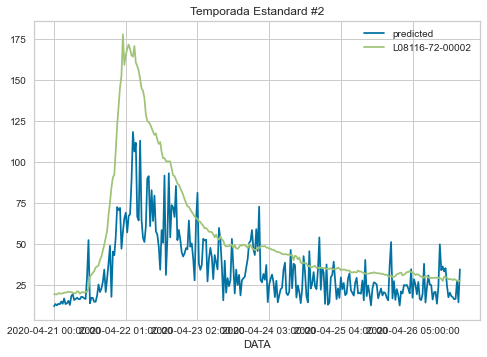

Iteració:  2
CPU times: total: 42.5 s
Wall time: 2min 1s


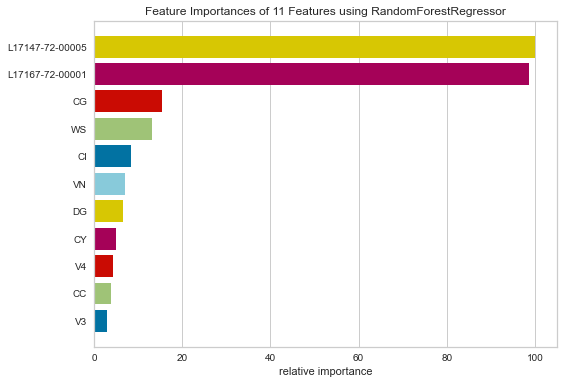

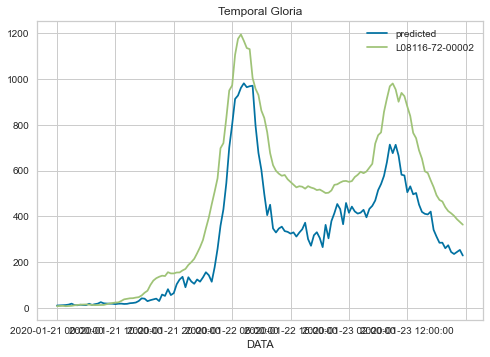

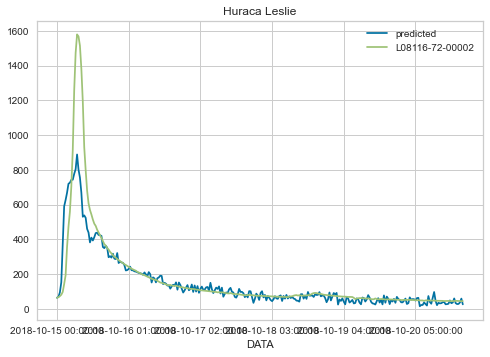

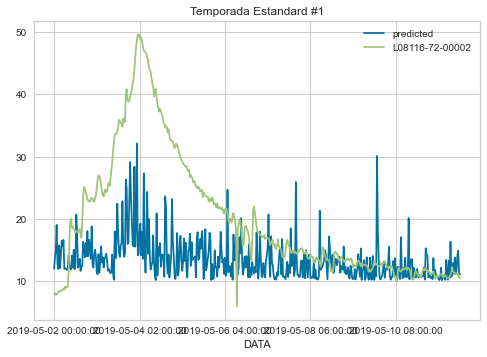

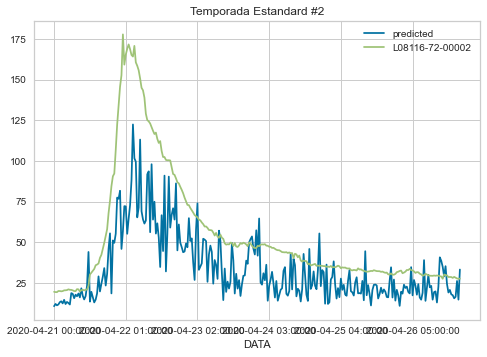

Iteració:  3
CPU times: total: 34.1 s
Wall time: 2min 32s


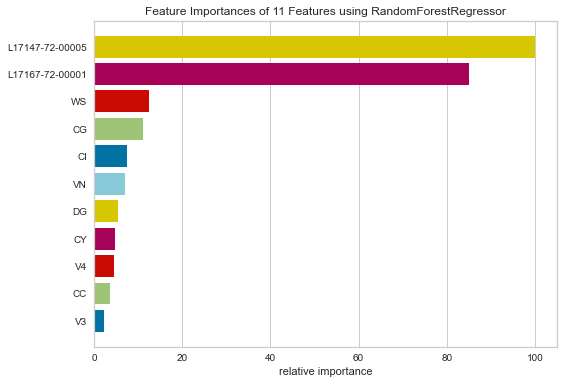

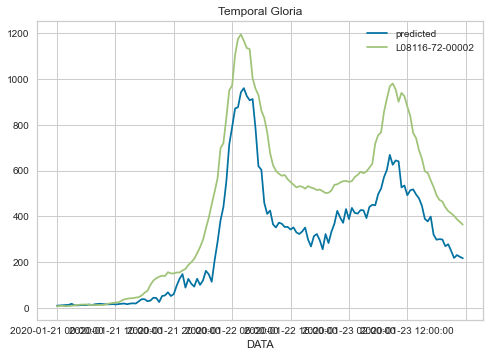

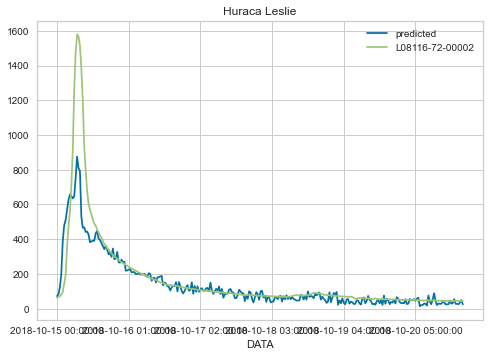

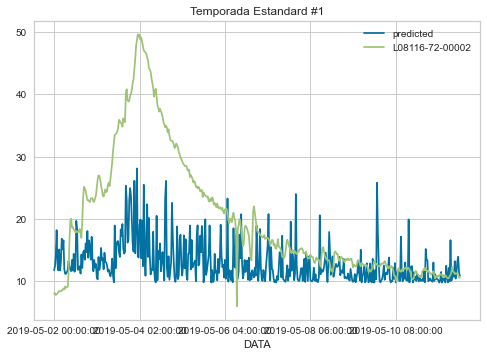

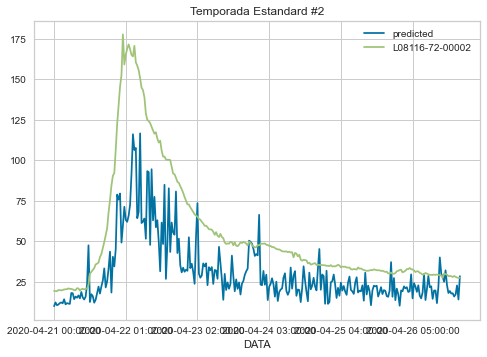

Time:  0:05:43.108586


In [50]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
   
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# XGBoost (Alt Ter)

Iteració:  1
[00:22:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 11.8 s
Wall time: 25.1 s


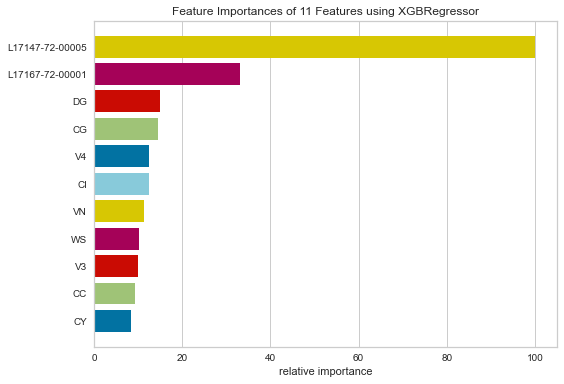

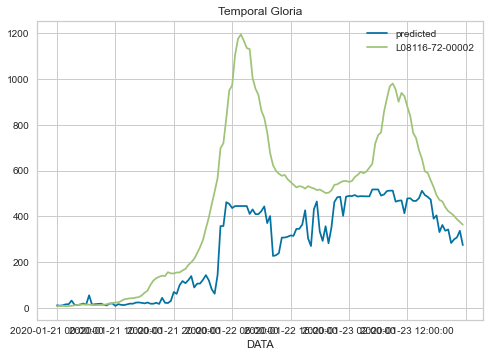

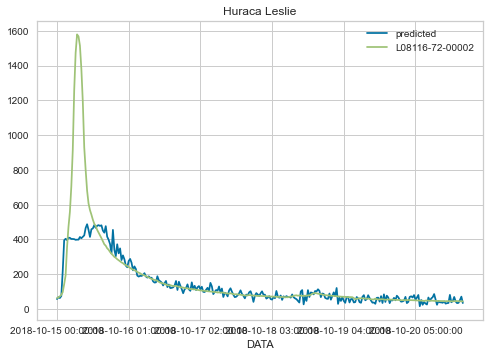

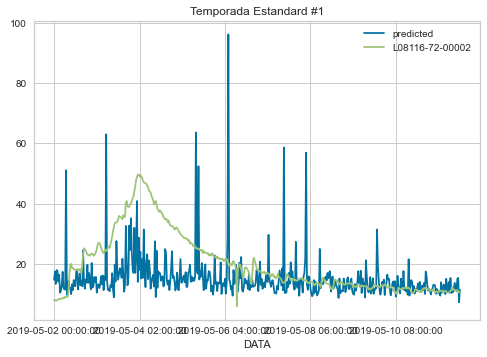

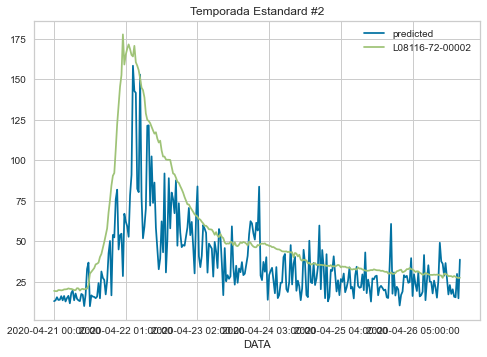

Iteració:  2
[00:23:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 21.2 s
Wall time: 48.5 s


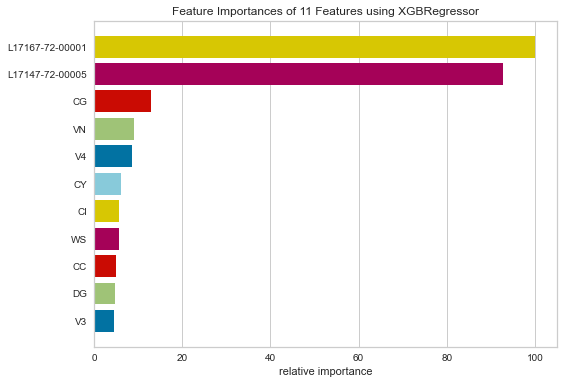

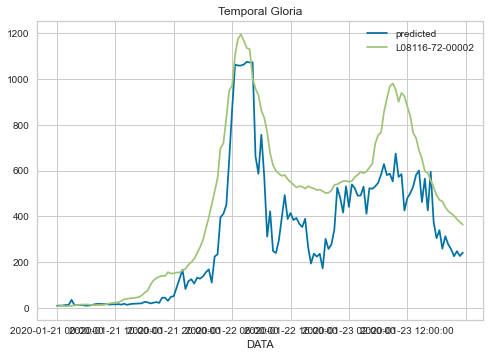

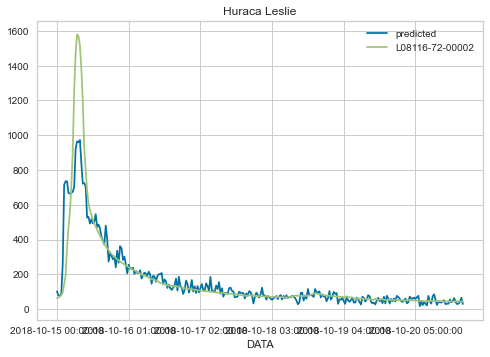

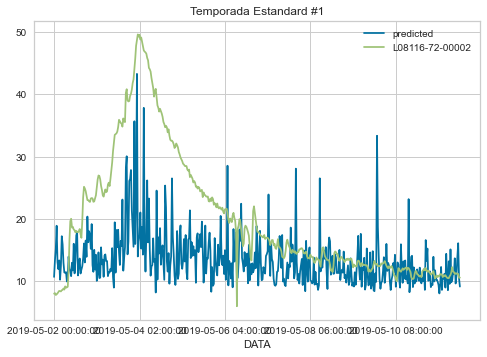

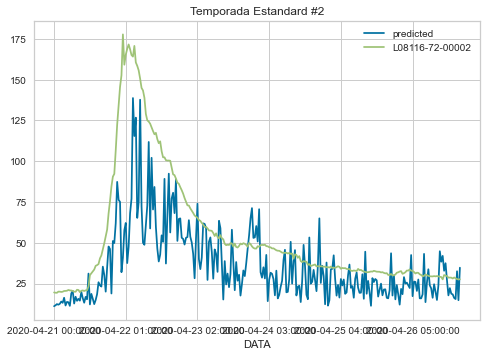

Iteració:  3
[00:24:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 31.8 s
Wall time: 1min 10s


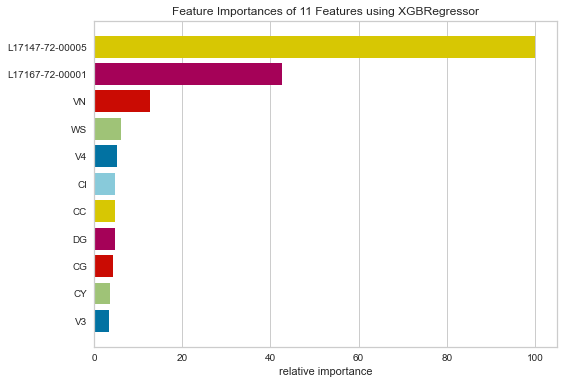

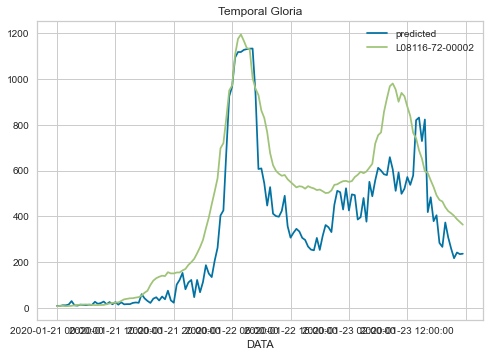

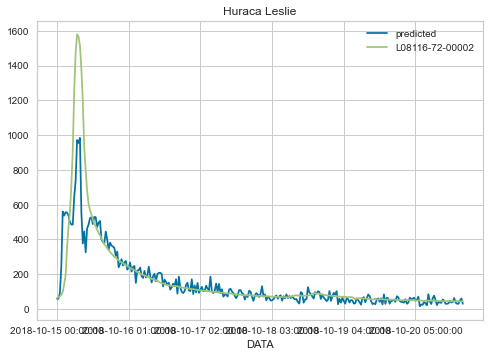

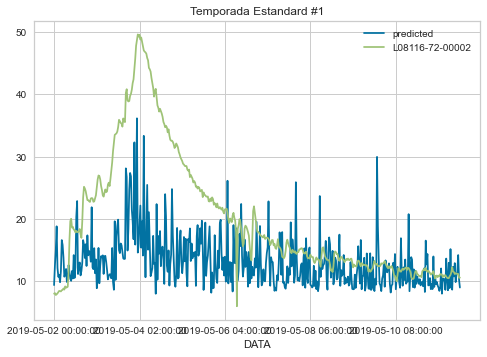

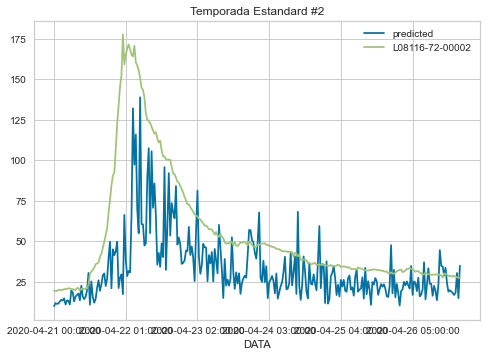

Time:  0:02:25.337651


In [51]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)

    new_row = {'Method':'XGBoost','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()
    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

## LightGBM (Alt Ter)

2012-01-01 23:00:00


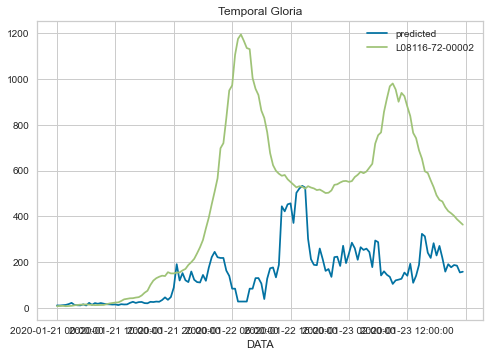

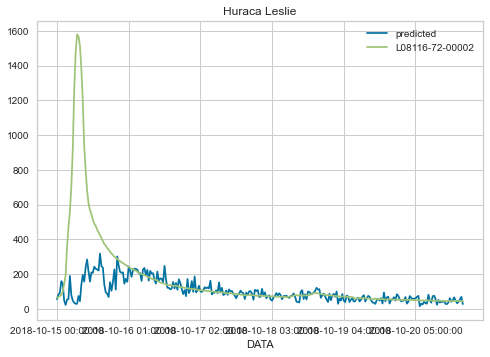

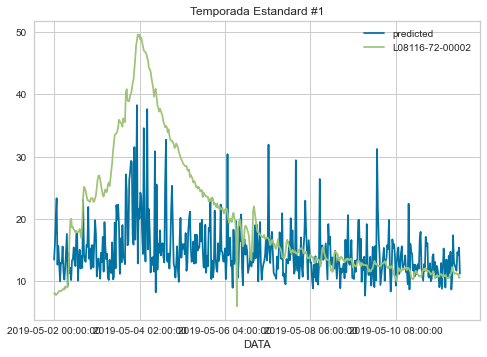

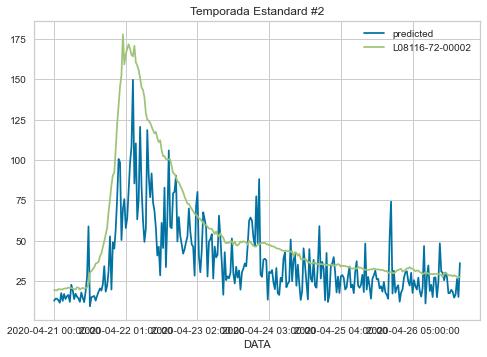

2015-01-01 15:30:00


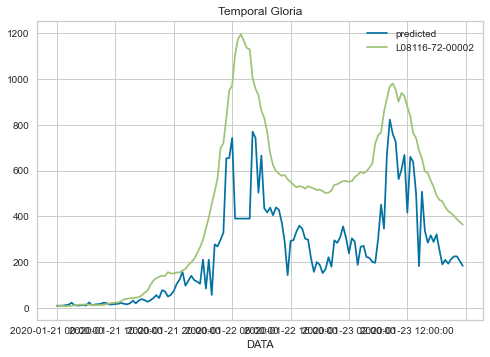

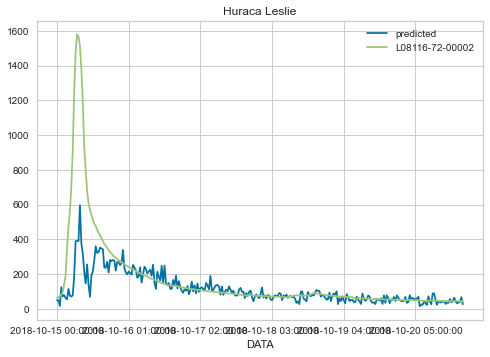

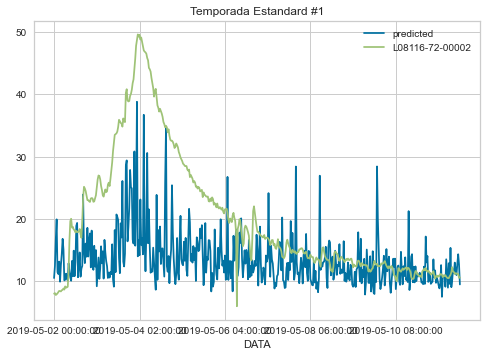

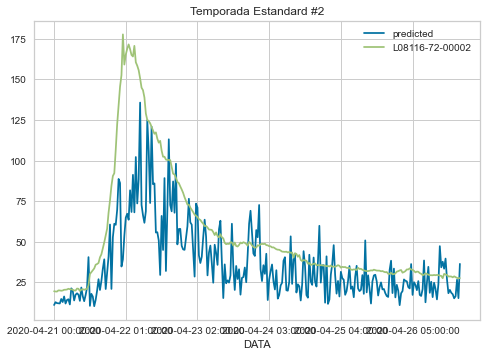

2018-01-01 08:00:00


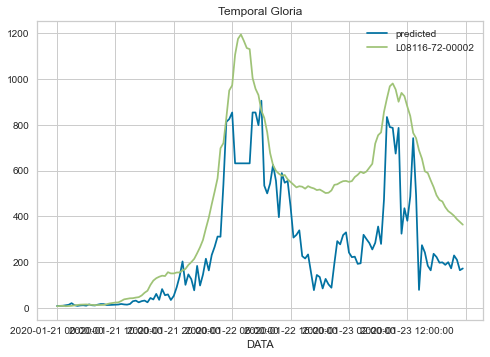

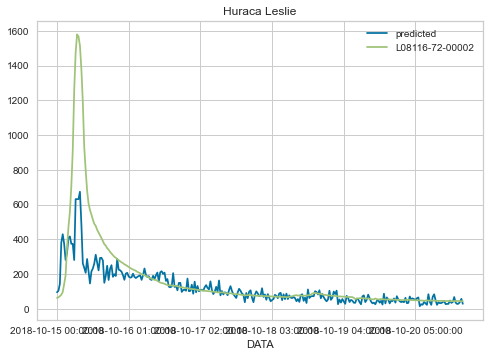

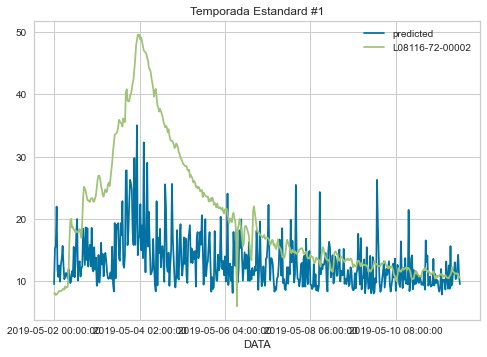

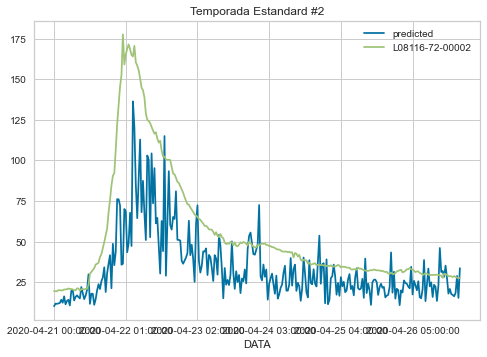

Time:  0:01:56.827356


In [52]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}


iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]
    
    print(Df_AltX.iloc[test_index].index[0])

    model = lgb.LGBMRegressor(first_metric_only = True, **param_search)
    
    model.fit(Df_AltX_train, Df_Alty_train,
          eval_metric = 'l1', 
          eval_set = [(Df_AltX_test, Df_Alty_test)],
          #early_stopping_rounds = 10,
          verbose = 0)
    predicty = model.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/XGBoost_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_AltX, Df_Alty)
    #viz.show()
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'LightGBM','RMSE Total':rmseScore,'Score':None,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# ExtraTrees (Alt Ter)

Iteració:  1
CPU times: total: 1.89 s
Wall time: 9.6 s


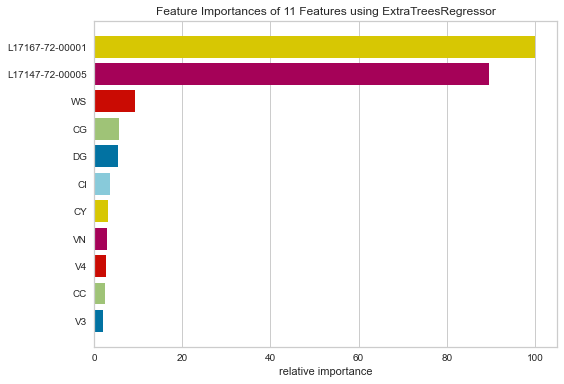

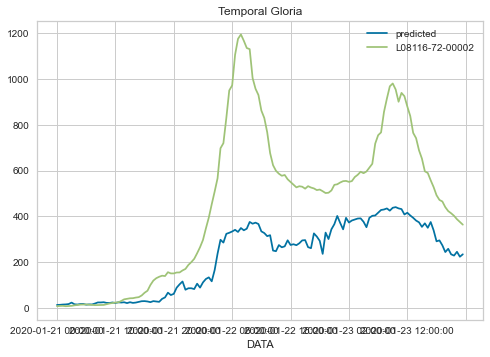

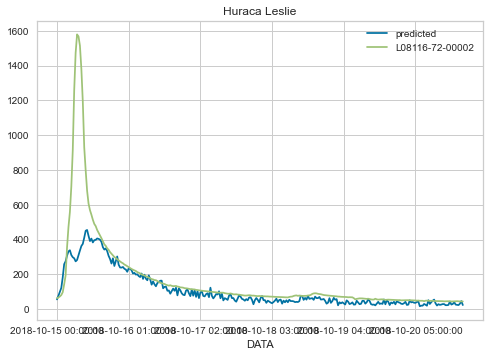

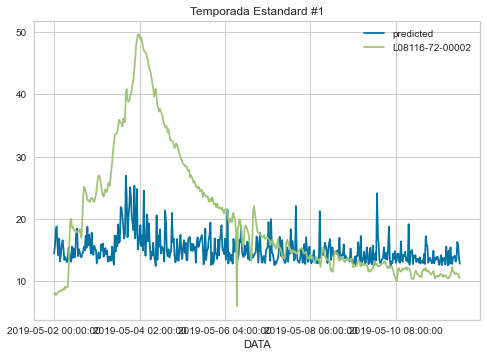

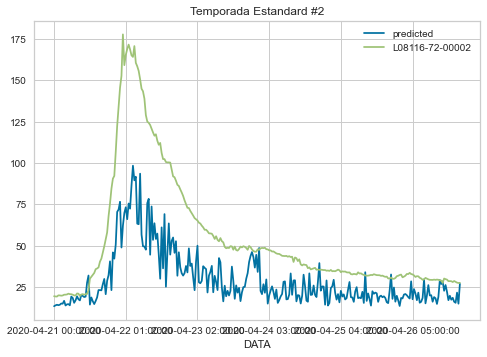

Iteració:  2
CPU times: total: 1.89 s
Wall time: 11.5 s


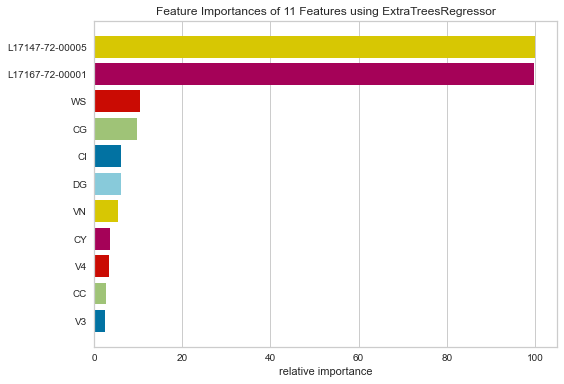

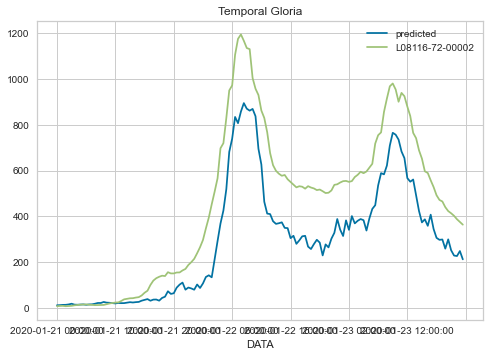

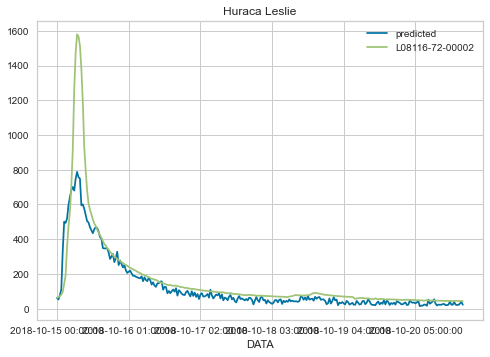

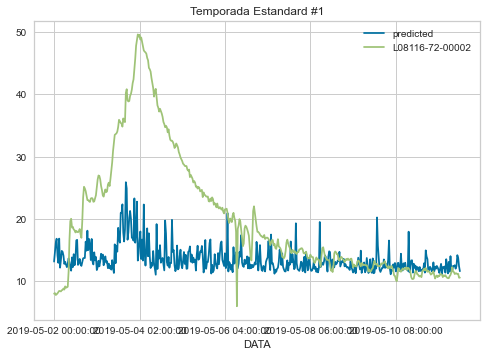

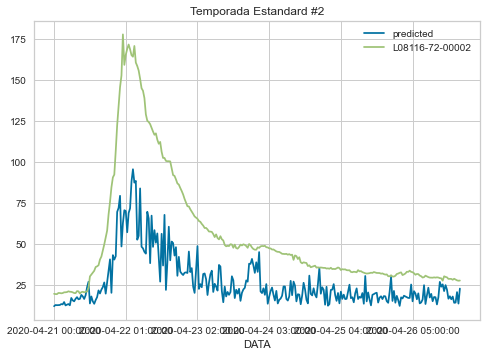

Iteració:  3
CPU times: total: 15.4 s
Wall time: 49.6 s


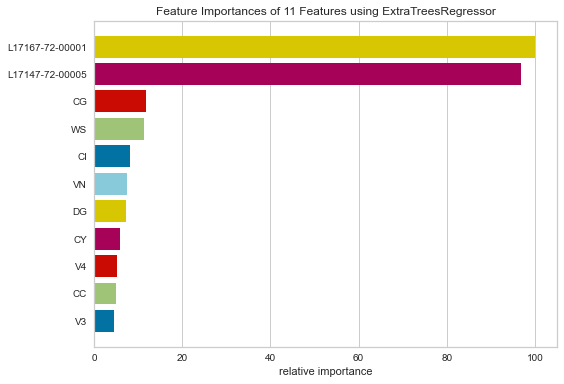

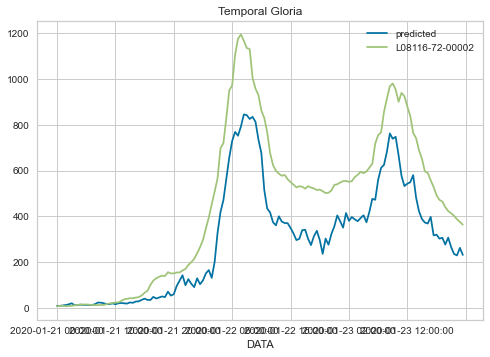

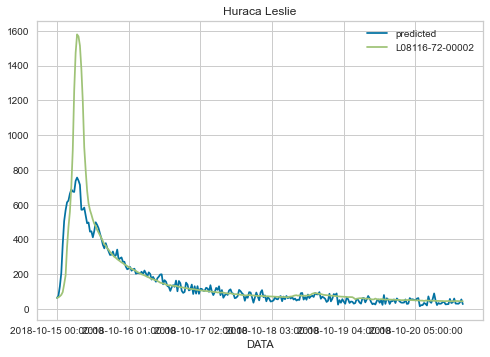

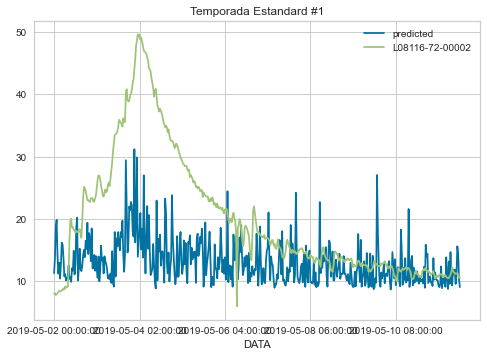

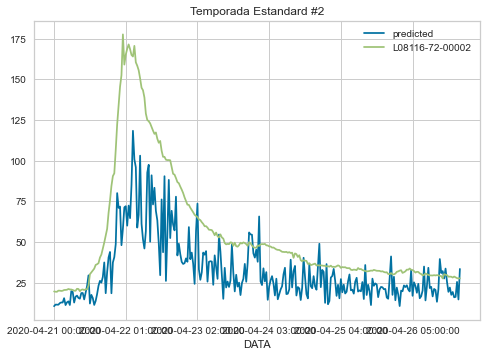

Time:  0:01:15.349816


In [53]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
   
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Extra Trees','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# Linear Regression (Alt Ter)

Iteració:  1
CPU times: total: 0 ns
Wall time: 7.01 ms


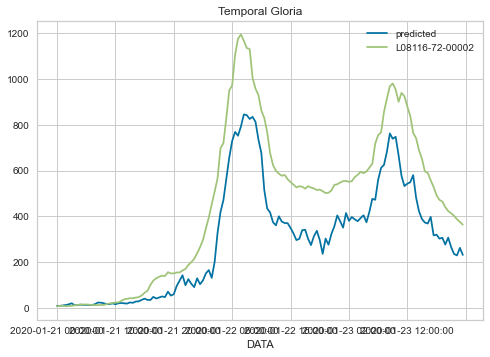

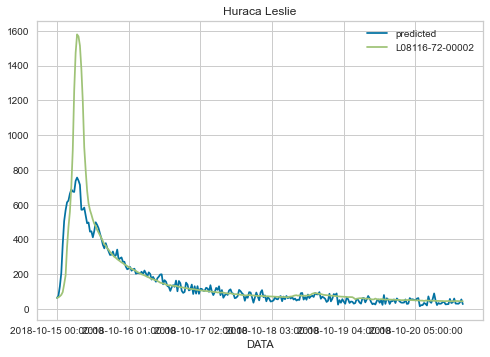

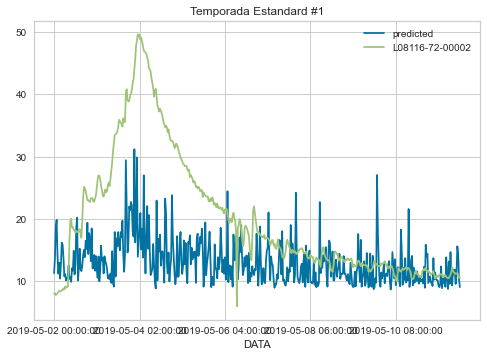

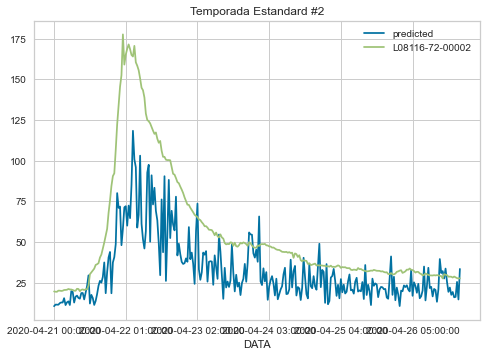

Iteració:  2
CPU times: total: 93.8 ms
Wall time: 17 ms


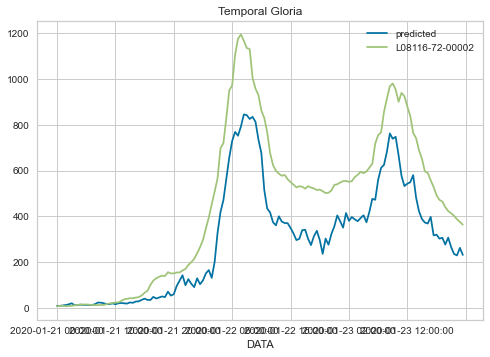

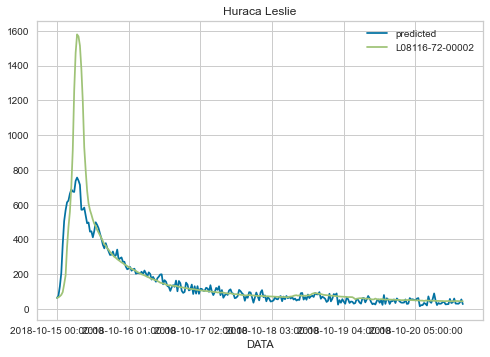

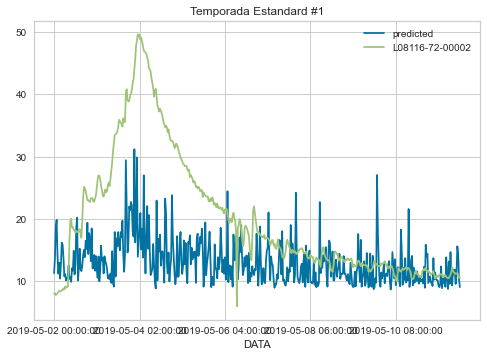

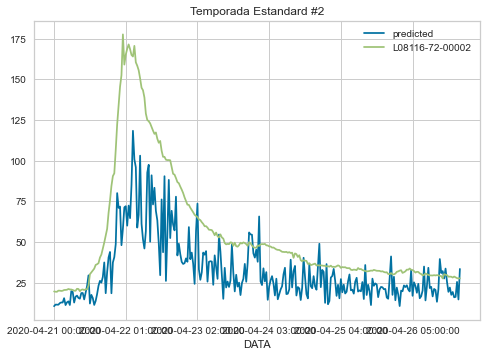

Iteració:  3
CPU times: total: 15.6 ms
Wall time: 27 ms


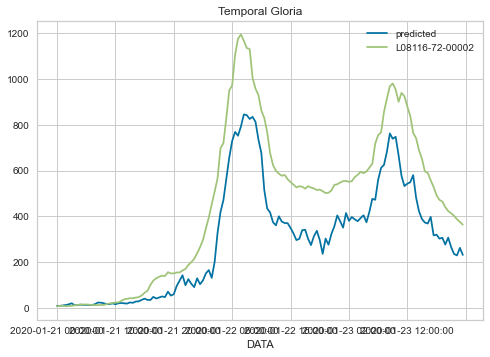

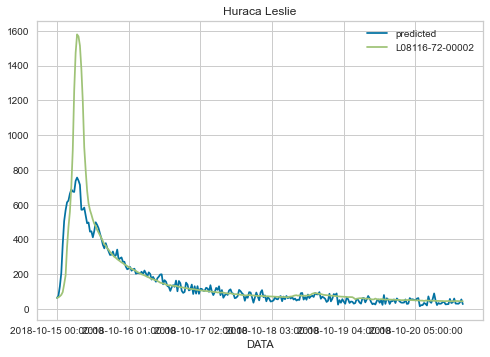

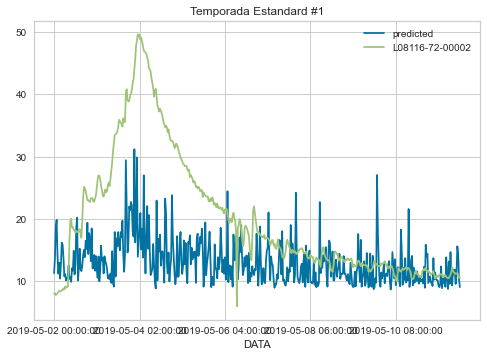

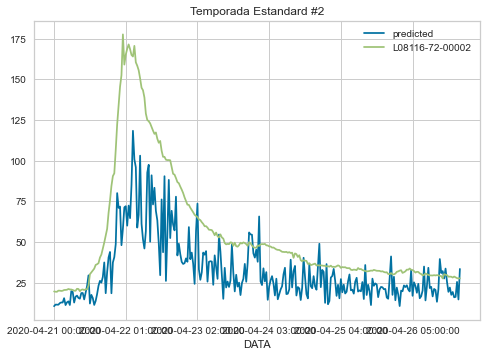

Time:  0:00:01.488730


In [54]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_AltX_train, Df_Alty_train)
        
    score = modelfited.score(Df_AltX_test, Df_Alty_test)
    
    predicty = modelfited.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    

    hores = "1 day"
    
    
    
    joblib.dump(modelfited, 'resultsDf/pickle/partAlta/LinearRegression_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)
    
    plotYtestAnomaly1 = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Alty["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Alty["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Alty["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_AltX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_AltX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_AltX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [55]:
df_results_altTer

Method     Score Prediccio_Hores  RMSE Total  RMSE_Leslie  \
0       Random Forest  0.689615           1 day   14.550845   181.949676   
1       Random Forest  0.648539           1 day    8.805788   124.751747   
2       Random Forest   0.79323           1 day   18.819238   130.476426   
3             XGBoost   0.67147           1 day   14.970129   173.379547   
4             XGBoost  0.452884           1 day   10.986752   108.154416   
5             XGBoost  0.807315           1 day   18.166949   129.768727   
6            LightGBM      None           1 day   19.057957   244.322127   
7            LightGBM      None           1 day   10.844855   200.551411   
8            LightGBM      None           1 day   23.079599   173.356947   
9         Extra Trees  0.682141           1 day   14.724996   188.387793   
10        Extra Trees  0.632817           1 day    9.000581   126.230258   
11        Extra Trees  0.798018           1 day   18.600081   130.349173   
12  Linear Regression  0.687389           1 day   14.602935   130.349173   
13  Linear Regression  0.526011           1 day   10.226185   130.349173   
14  Linear Regression  0.733269           1 day   21.374459   130.349173   

    RMSE_Standard1  RMSE_Standard2  RSME_Gloria  
0        10.575322       30.600761   306.116411  
1        11.114621       30.322827   182.200118  
2        11.391057       32.139487   190.339429  
3        11.854296       29.637549   267.220831  
4        10.986789       30.773771   186.840254  
5        11.151454       35.038275   169.672818  
6        10.525377       28.998890   433.078413  
7        10.975845       29.910214   276.264677  
8        11.191957       31.585345   255.205622  
9        10.398361       33.630334   310.545077  
10       11.196096       35.918227   193.107192  
11       11.306786       31.637653   188.635023  
12       11.306786       31.637653   188.635023  
13       11.306786       31.637653   188.635023  
14       11.306786       31.637653   188.635023

In [56]:
df_results_altTer.drop(columns=['Score','Prediccio_Hores'], inplace=True)
df_results_altTer.rename(columns={'RMSE_Leslie':'Leslie','RMSE_Standard1':'Standard1','RMSE_Standard2':'Standard2','RSME_Gloria':
                                 'Gloria'},inplace=True)
df_results_altTer = df_results_altTer.sort_values(by=['RMSE Total'])
df_results_altTer.to_latex('dfAltNormal.tex',index=False)
df_results_altTer

Method  RMSE Total      Leslie  Standard1  Standard2  \
1       Random Forest    8.805788  124.751747  11.114621  30.322827   
10        Extra Trees    9.000581  126.230258  11.196096  35.918227   
13  Linear Regression   10.226185  130.349173  11.306786  31.637653   
7            LightGBM   10.844855  200.551411  10.975845  29.910214   
4             XGBoost   10.986752  108.154416  10.986789  30.773771   
0       Random Forest   14.550845  181.949676  10.575322  30.600761   
12  Linear Regression   14.602935  130.349173  11.306786  31.637653   
9         Extra Trees   14.724996  188.387793  10.398361  33.630334   
3             XGBoost   14.970129  173.379547  11.854296  29.637549   
5             XGBoost   18.166949  129.768727  11.151454  35.038275   
11        Extra Trees   18.600081  130.349173  11.306786  31.637653   
2       Random Forest   18.819238  130.476426  11.391057  32.139487   
6            LightGBM   19.057957  244.322127  10.525377  28.998890   
14  Linear Regression   21.374459  130.349173  11.306786  31.637653   
8            LightGBM   23.079599  173.356947  11.191957  31.585345   

        Gloria  
1   182.200118  
10  193.107192  
13  188.635023  
7   276.264677  
4   186.840254  
0   306.116411  
12  188.635023  
9   310.545077  
3   267.220831  
5   169.672818  
11  188.635023  
2   190.339429  
6   433.078413  
14  188.635023  
8   255.205622

# Models Baix Ter

# Random Forest (Baix Ter)

In [57]:
df_results_baixTer = pd.DataFrame(columns = ["Method","Score","RMSE_Score","Prediccio_Hores"])

Iteració:  1
CPU times: total: 15.6 s
Wall time: 47.5 s


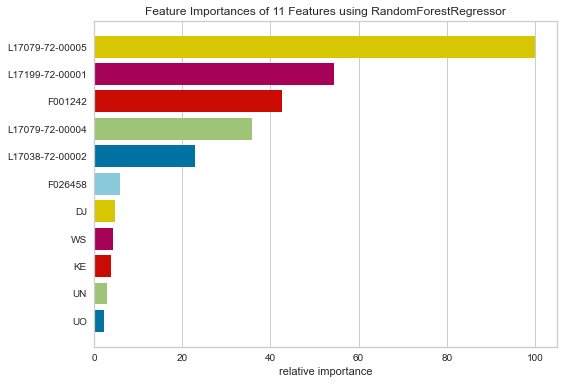

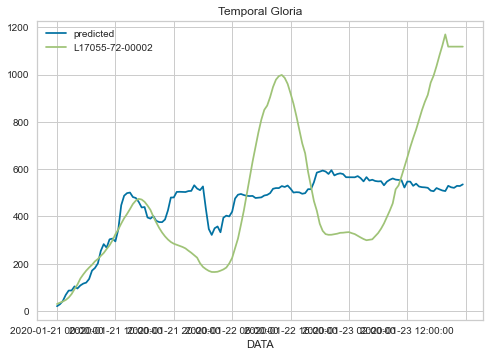

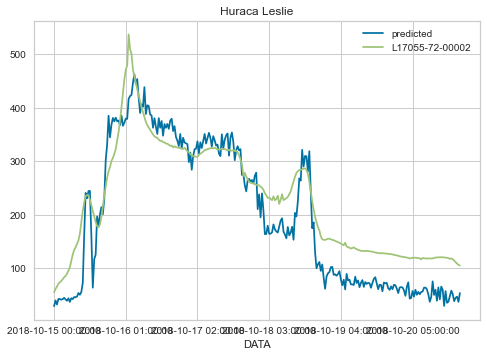

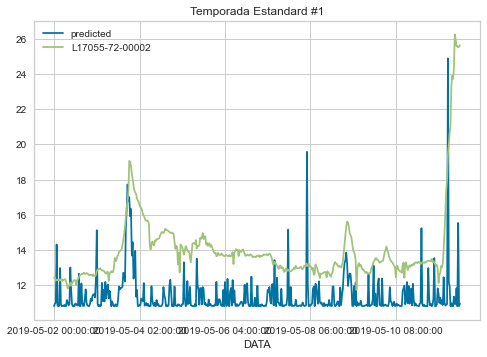

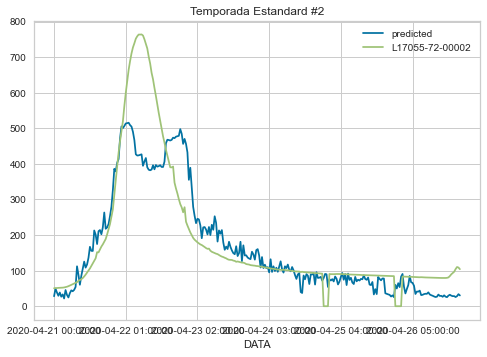

Iteració:  2
CPU times: total: 3.58 s
Wall time: 38.7 s


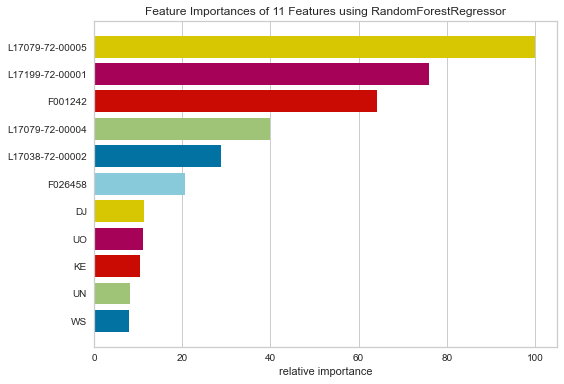

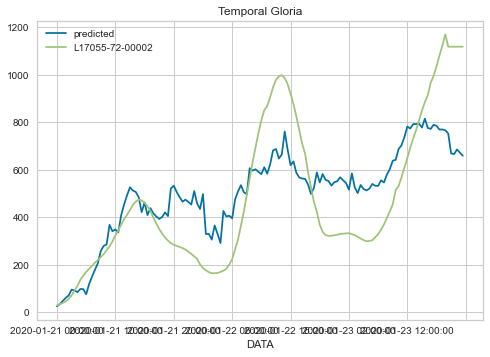

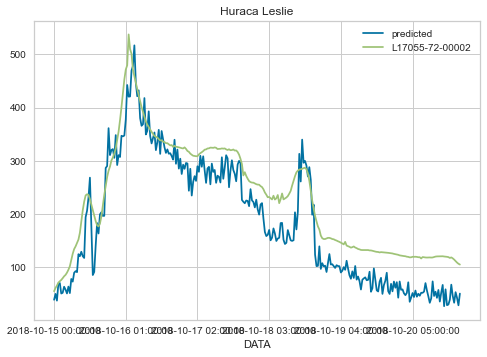

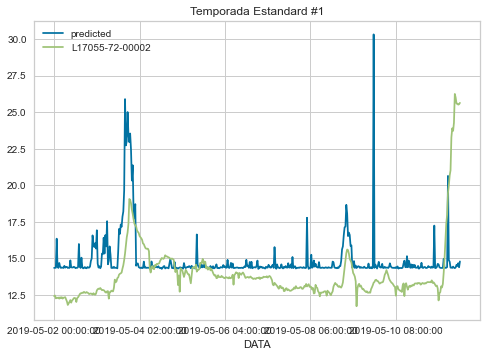

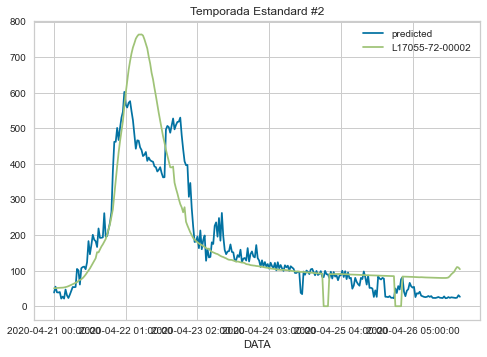

Iteració:  3
CPU times: total: 33.2 s
Wall time: 2min 19s


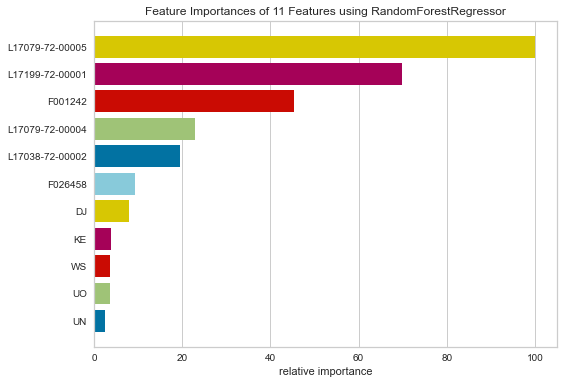

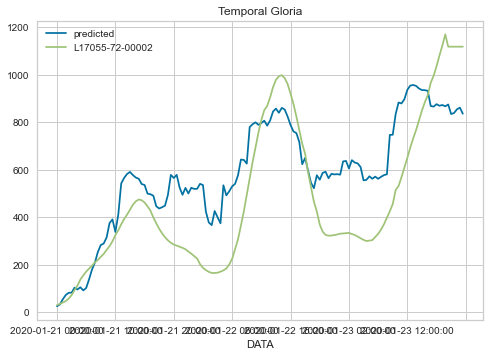

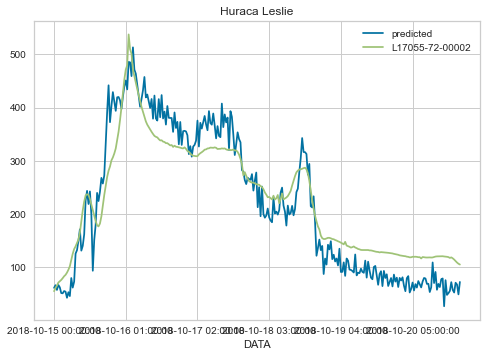

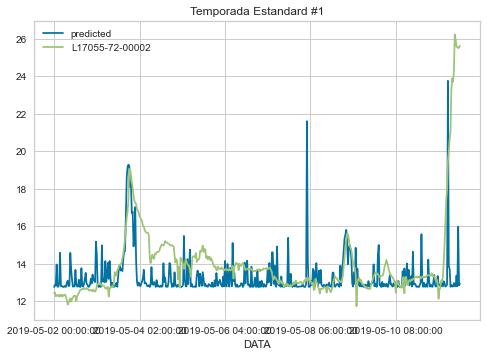

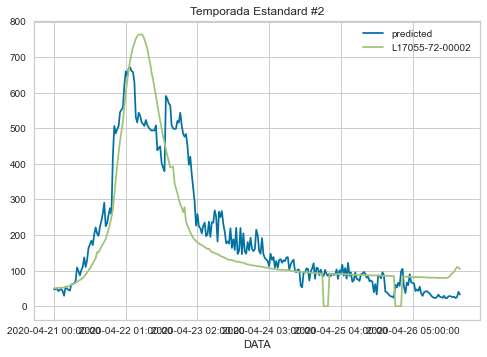

Time:  0:03:48.067290


In [58]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Random Forest','RMSE Total':rmseScore, 'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# XGBoost (Baix Ter)

Iteració:  1
[00:31:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 18.1 s
Wall time: 32.7 s


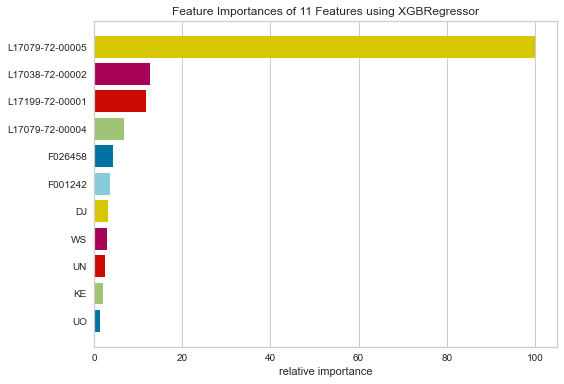

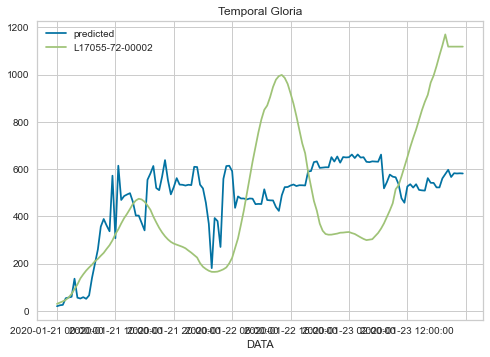

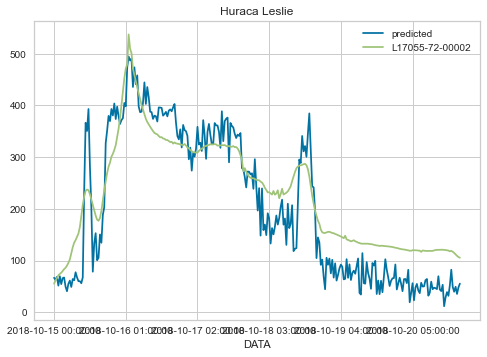

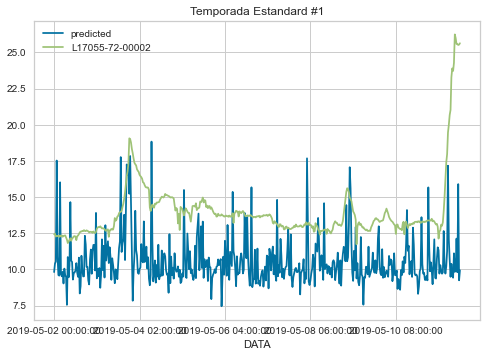

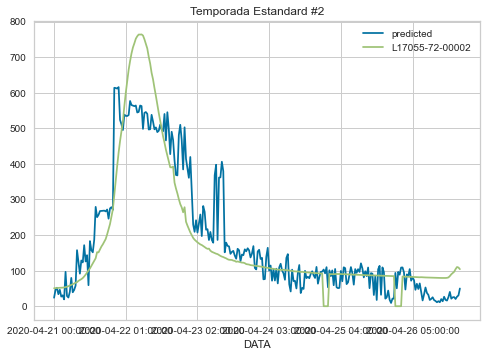

Iteració:  2
[00:32:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 20.9 s
Wall time: 44.4 s


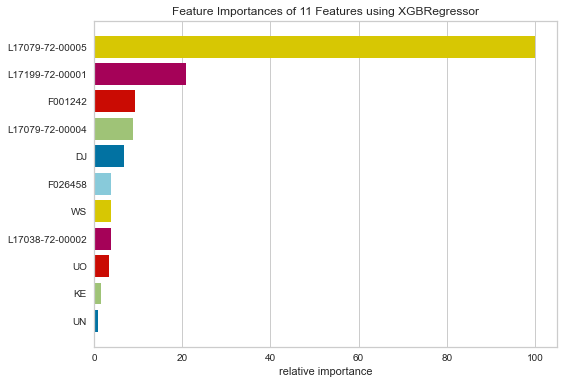

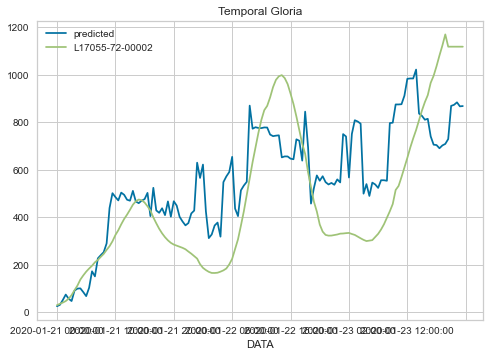

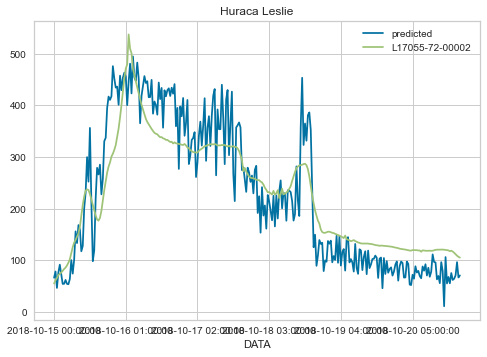

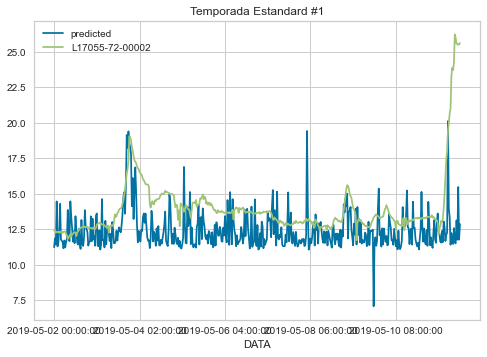

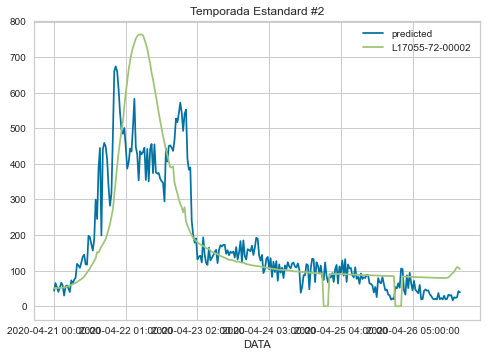

Iteració:  3
[00:34:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: total: 58.5 s
Wall time: 1min 54s


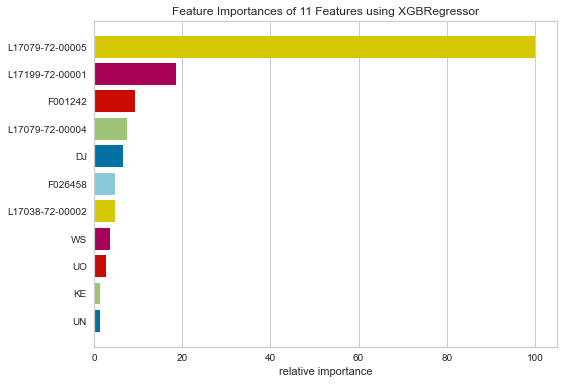

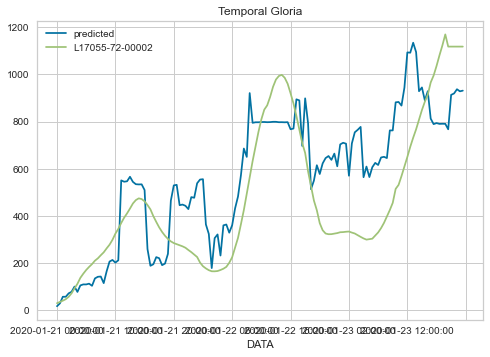

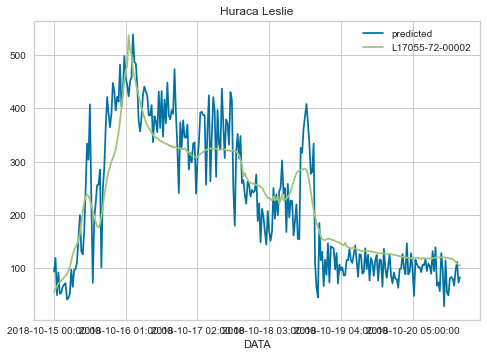

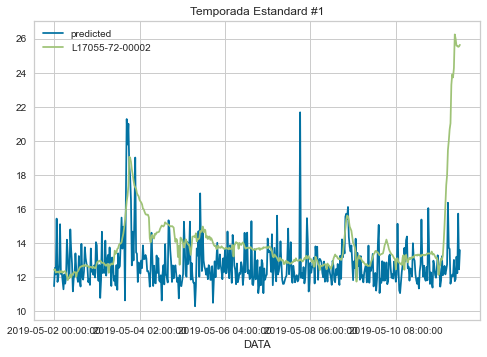

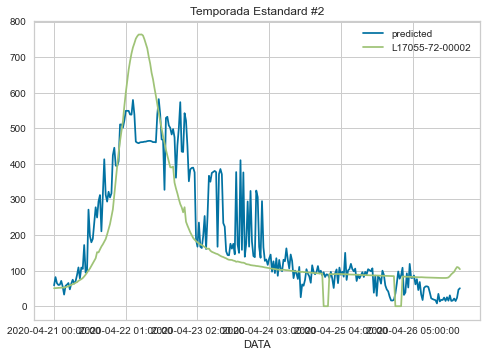

Time:  0:03:12.863968


In [59]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = xgb.XGBRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'XGBoost','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

## LightGBM (Baix Ter)

2012-01-01 23:00:00


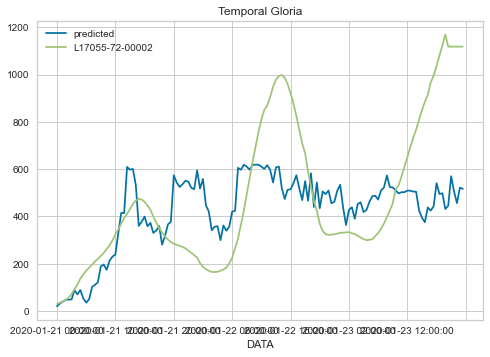

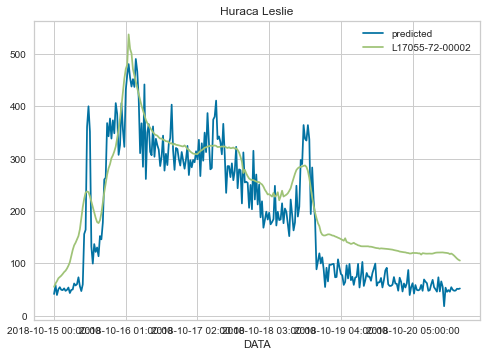

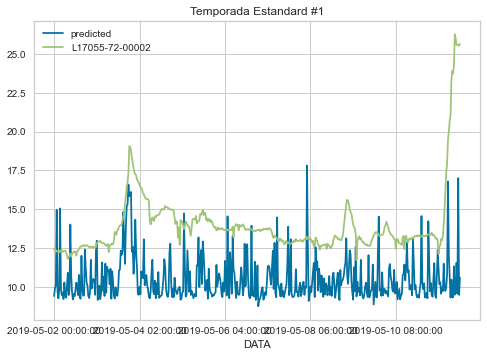

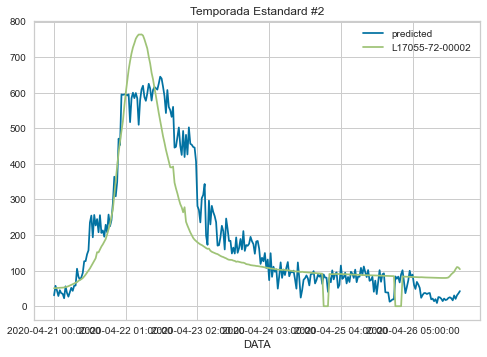

2015-01-01 15:30:00


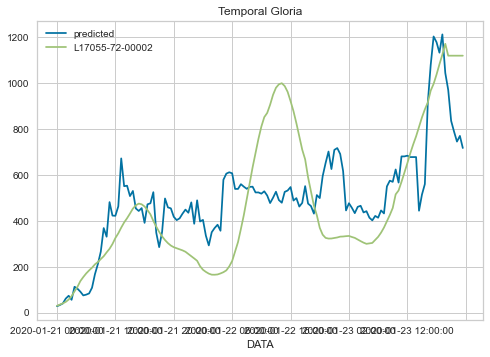

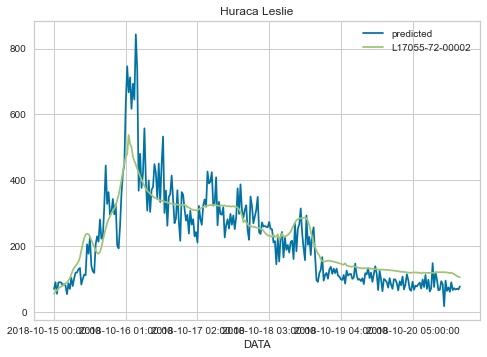

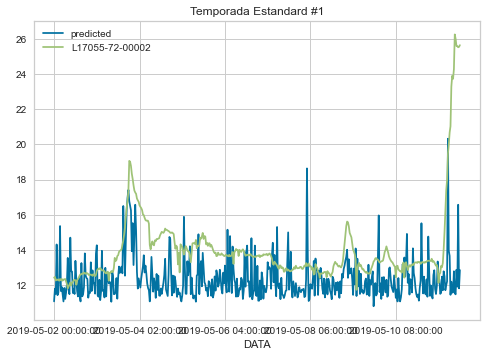

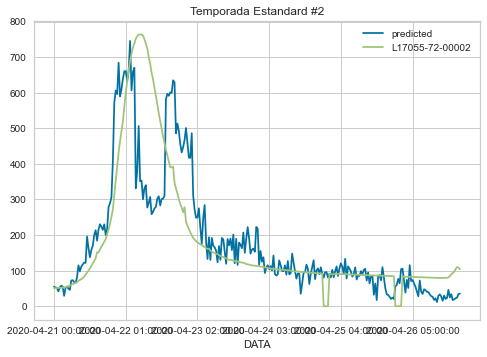

2018-01-01 08:00:00


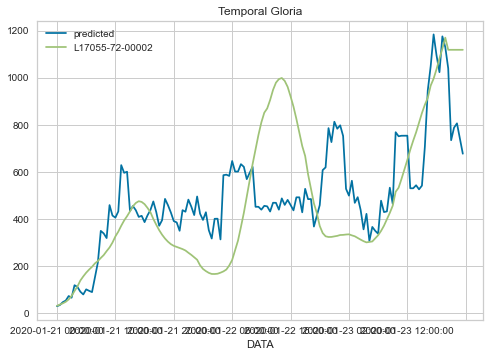

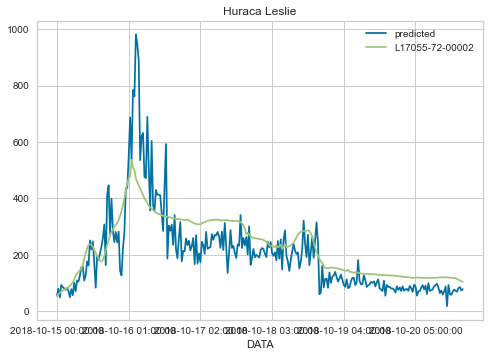

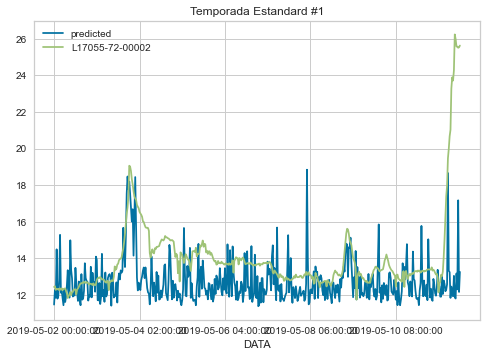

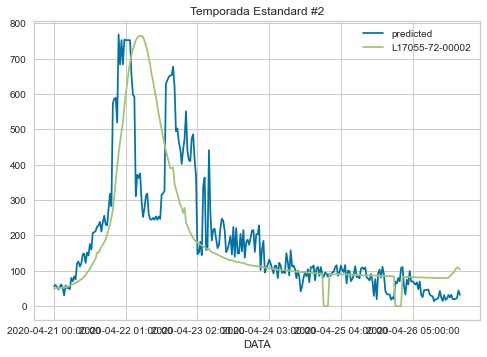

Time:  0:01:55.206242


In [60]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

#Calcular només amb els valors on plou


iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]
    
    print(Df_BaixX.iloc[test_index].index[0])

    model = lgb.LGBMRegressor(first_metric_only = True, **param_search)
    
    model.fit(Df_BaixX_train, Df_Baixy_train,
          eval_metric = 'l1', 
          eval_set = [(Df_BaixX_test, Df_Baixy_test)],
          #early_stopping_rounds = 10,
          verbose = 0)
    predicty = model.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    
    
    #joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partBaixa/XGBoost_'+str(df_results_BaixTer.index[-1])+'.pkl', compress = 1)

    #viz = FeatureImportances(gsearchfited.best_estimator_)
    #viz.fit(Df_BaixX, Df_Baixy)
    #viz.show()
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = model.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = model.predict(plotXtestAnomaly2.values)
    predictStandard1 = model.predict(plotXtestStandard1.values)
    predictStandard2 = model.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'LightGBM','RMSE Total':rmseScore,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# ExtraTrees (Baix Ter)

Iteració:  1
CPU times: total: 2.06 s
Wall time: 10.9 s


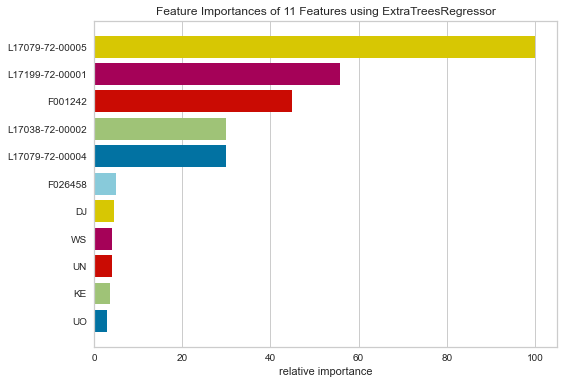

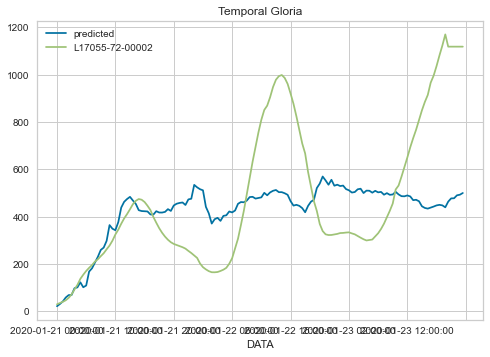

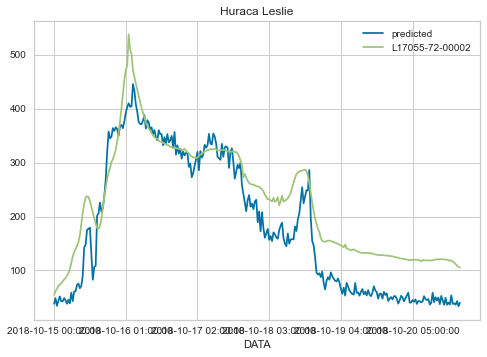

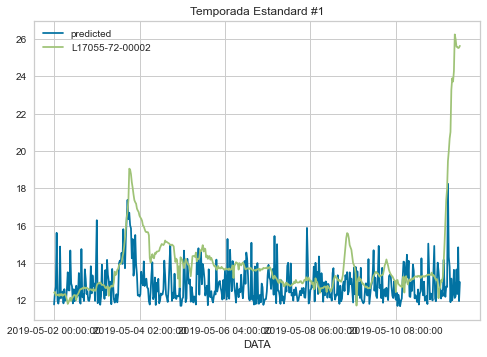

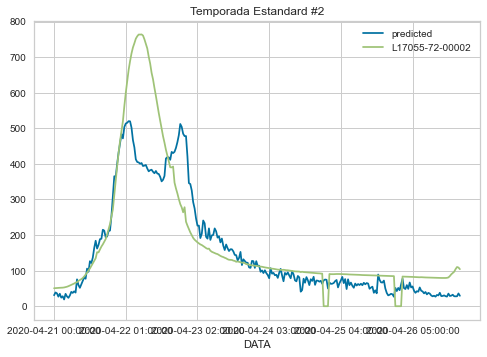

Iteració:  2
CPU times: total: 1.75 s
Wall time: 11.1 s


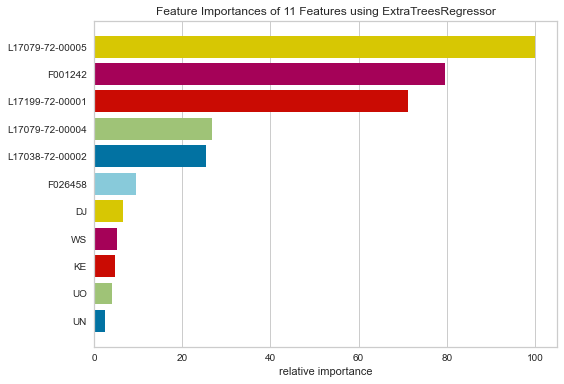

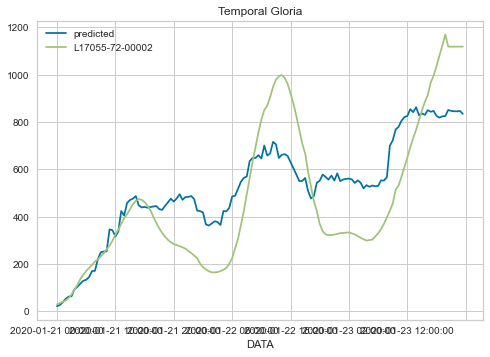

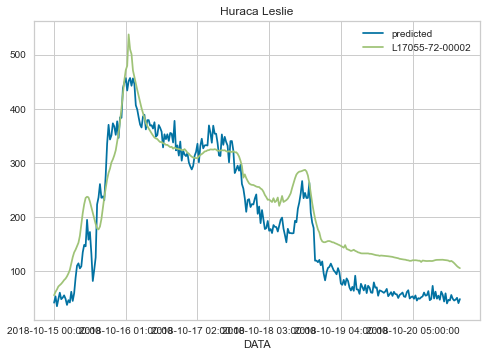

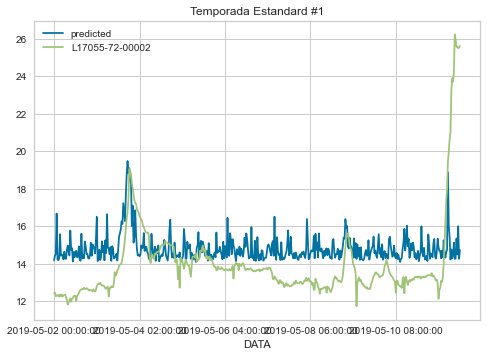

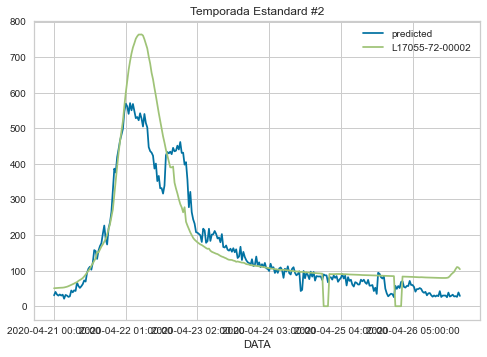

Iteració:  3
CPU times: total: 7.3 s
Wall time: 47.3 s


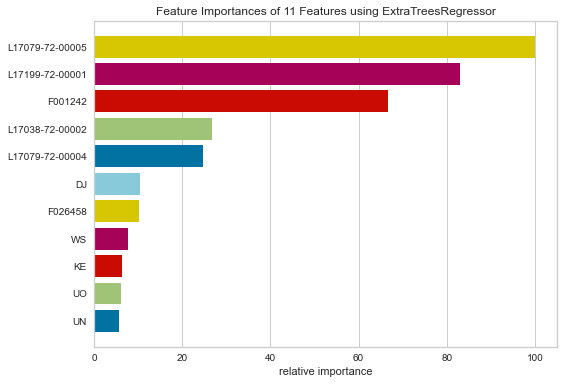

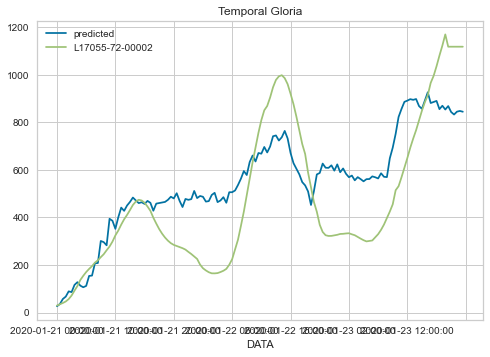

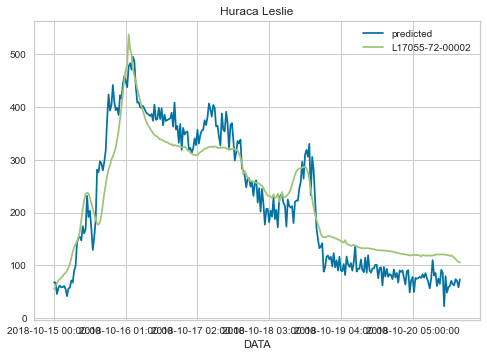

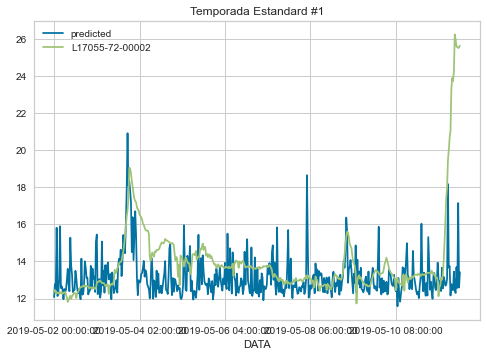

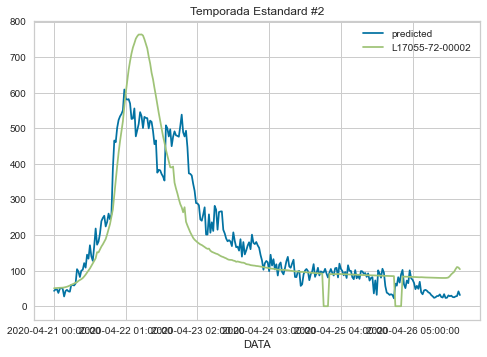

Time:  0:01:12.738060


In [61]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = ExtraTreesRegressor()
    tscv = TimeSeriesSplit()
    gsearch = HalvingGridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_BaixX_train, Df_Baixy_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_BaixX_test, Df_Baixy_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    
    nameh = Df_BaixX.columns[0]
    hores = "1 day"
    
    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_BaixX, Df_Baixy)
    viz.show()
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'ExtraTrees','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

# Linear Regression (Baix Ter)

Iteració:  1
CPU times: total: 0 ns
Wall time: 8.01 ms


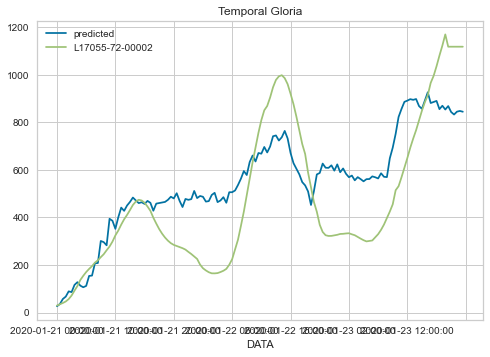

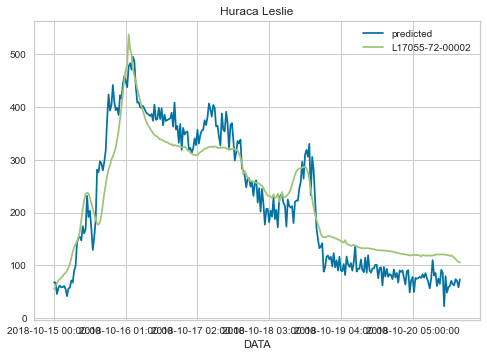

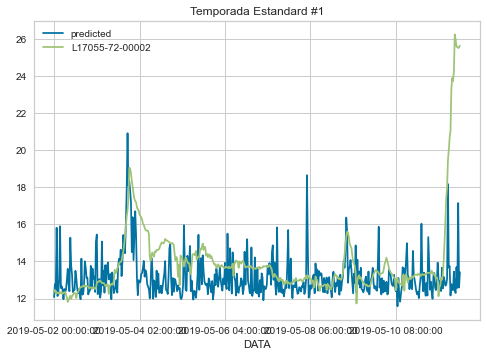

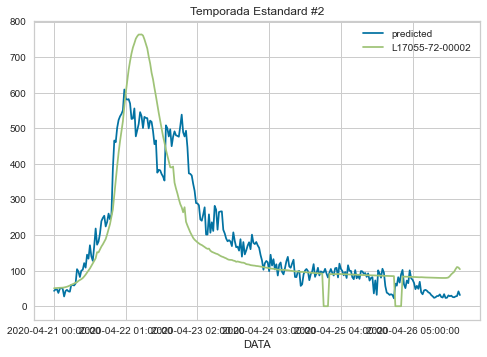

Iteració:  2
CPU times: total: 15.6 ms
Wall time: 17 ms


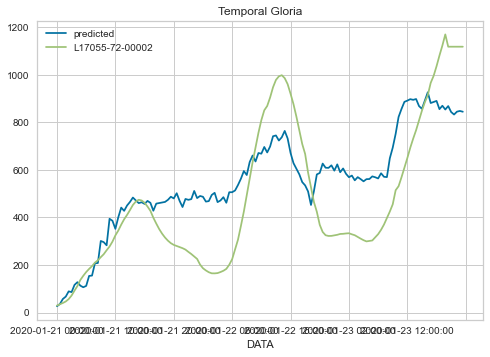

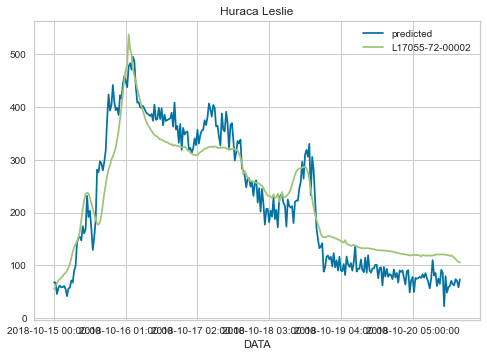

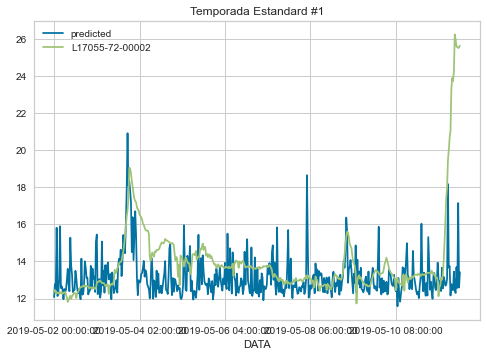

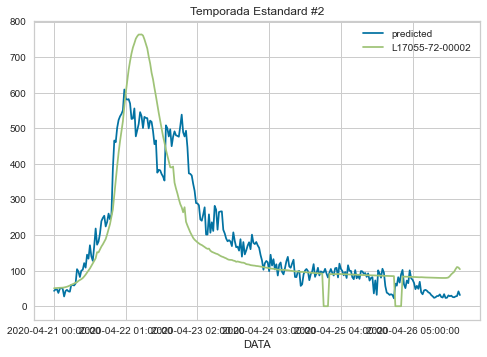

Iteració:  3
CPU times: total: 31.2 ms
Wall time: 28 ms


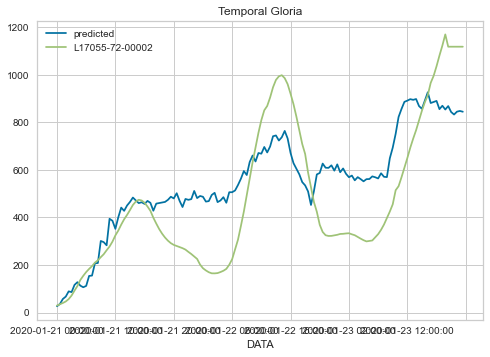

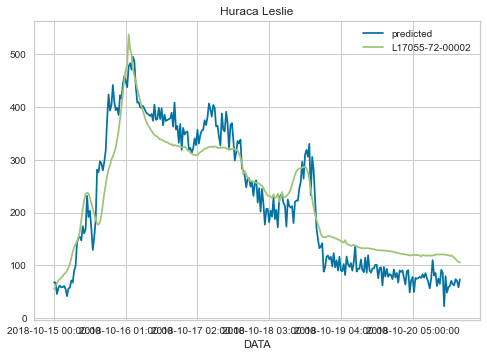

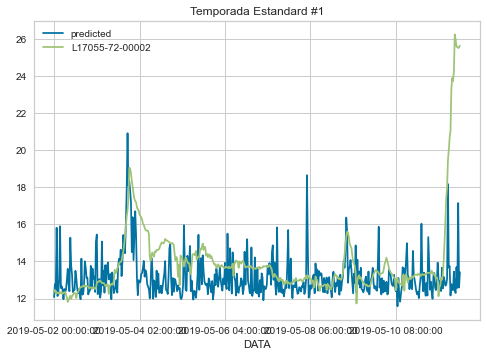

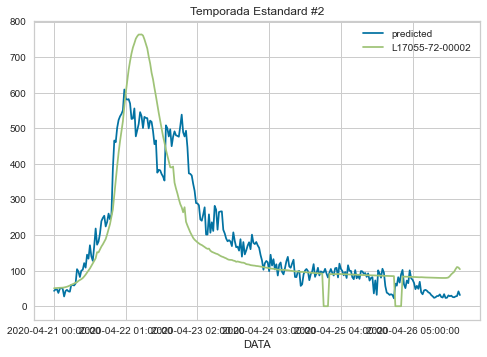

Time:  0:00:01.271271


In [62]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=3)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_BaixX):
    iteracio += 1
    Df_BaixX_train, Df_BaixX_test = Df_BaixX.values[train_index], Df_BaixX.values[test_index]
    Df_Baixy_train, Df_Baixy_test = Df_Baixy.values.ravel()[train_index], Df_Baixy.values.ravel()[test_index]

    model = LinearRegression()
    print("Iteració: ", iteracio)
    %time modelfited = model.fit(Df_BaixX_train, Df_Baixy_train)
        
    score = modelfited.score(Df_BaixX_test, Df_Baixy_test)
    
    predicty = modelfited.predict(Df_BaixX_test)
    rmseScore = mean_squared_error(Df_Baixy_test, predicty, squared=False)
    

    hores = "1 day"
    
    plotYtestAnomaly1 = Df_Baixy["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtestAnomaly2 = Df_Baixy["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotYtestStandard1 = Df_Baixy["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotYtestStandard2 = Df_Baixy["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    
    plotXtestAnomaly1 = Df_BaixX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtestAnomaly2 = Df_BaixX["2018-10-14 5:00:00":"2018-10-20 21:30:00"]
    plotXtestStandard1 = Df_BaixX["2019-05-01 5:00:00":"2019-05-11 21:30:00"]
    plotXtestStandard2 = Df_BaixX["2020-04-20 5:00:00":"2020-04-26 21:30:00"]
    

    
    predictAnomaly1 = gsearchfited.best_estimator_.predict(plotXtestAnomaly1.values)
    predictAnomaly2 = gsearchfited.best_estimator_.predict(plotXtestAnomaly2.values)
    predictStandard1 = gsearchfited.best_estimator_.predict(plotXtestStandard1.values)
    predictStandard2 = gsearchfited.best_estimator_.predict(plotXtestStandard2.values)
    
    rmseScoreAnomaly1 = mean_squared_error(plotYtestAnomaly1, predictAnomaly1, squared=False)
    rmseScoreAnomaly2 = mean_squared_error(plotYtestAnomaly2, predictAnomaly2, squared=False)
    rmseScoreStandard1 = mean_squared_error(plotYtestStandard1, predictStandard1, squared=False)
    rmseScoreStandard2 = mean_squared_error(plotYtestStandard2, predictStandard2, squared=False)
    
    plotYtestAnomaly1.insert(0, 'predicted', predictAnomaly1, allow_duplicates=True)
    plotYtestAnomaly2.insert(0, 'predicted', predictAnomaly2, allow_duplicates=True)
    plotYtestStandard1.insert(0, 'predicted', predictStandard1, allow_duplicates=True)
    plotYtestStandard2.insert(0, 'predicted', predictStandard2, allow_duplicates=True)
    
    new_row = {'Method':'Linear Regression','RMSE Total':rmseScore,'Score':score,"Prediccio_Hores":hores,
              'RSME_Gloria':rmseScoreAnomaly1, 'RMSE_Leslie':rmseScoreAnomaly2,'RMSE_Standard1':rmseScoreStandard1,'RMSE_Standard2':rmseScoreStandard2}
    df_results_baixTer = df_results_baixTer.append(new_row, ignore_index=True)

    plotYtestAnomaly1.plot(title="Temporal Gloria")
    plotYtestAnomaly2.plot(title="Huraca Leslie")
    plotYtestStandard1.plot(title="Temporada Estandard #1")
    plotYtestStandard2.plot(title="Temporada Estandard #2")
    plt.show()


    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [63]:
df_results_baixTer

Method     Score RMSE_Score Prediccio_Hores  RMSE Total  \
0       Random Forest  0.732572        NaN           1 day   17.910053   
1       Random Forest  0.358366        NaN           1 day    5.474118   
2       Random Forest  0.681821        NaN           1 day   32.364492   
3             XGBoost   0.68282        NaN           1 day   19.505015   
4             XGBoost  0.475184        NaN           1 day    4.950786   
5             XGBoost  0.654919        NaN           1 day   33.704932   
6          ExtraTrees  0.719929        NaN           1 day   18.328509   
7          ExtraTrees  0.405163        NaN           1 day    5.270716   
8          ExtraTrees   0.67582        NaN           1 day   32.668286   
9   Linear Regression  0.675835        NaN           1 day   19.718621   
10  Linear Regression -0.494881        NaN           1 day    8.355526   
11  Linear Regression  0.661081        NaN           1 day   33.402649   

    RMSE_Leslie  RMSE_Standard1  RMSE_Standard2  RSME_Gloria  
0     54.409785        3.375931       95.606456   265.135215  
1     54.182573        2.561396       91.477102   194.916731  
2     46.237031        2.253019       84.931268   202.333867  
3     60.819139        4.212844       85.998309   289.328904  
4     58.292891        2.719697      114.149487   223.742174  
5     56.755648        2.600357      106.740556   221.072129  
6     60.298088        2.438551       97.205728   277.162085  
7     51.849562        2.257579       74.385966   184.872960  
8     45.319728        2.326074       85.229628   198.109588  
9     45.319728        2.326074       85.229628   198.109588  
10    45.319728        2.326074       85.229628   198.109588  
11    45.319728        2.326074       85.229628   198.109588

In [64]:
df_results_baixTer.drop(columns=['Score','Prediccio_Hores', 'RMSE_Score'], inplace=True)
df_results_baixTer.rename(columns={'RMSE_Leslie':'Leslie','RMSE_Standard1':'Standard1','RMSE_Standard2':'Standard2','RSME_Gloria':
                                 'Gloria'},inplace=True)
df_results_baixTer = df_results_baixTer.sort_values(by=['RMSE Total'])
df_results_baixTer.to_latex('dfBaixNormal.tex',index=False)
df_results_baixTer

Method  RMSE Total     Leslie  Standard1   Standard2  \
4             XGBoost    4.950786  58.292891   2.719697  114.149487   
7          ExtraTrees    5.270716  51.849562   2.257579   74.385966   
1       Random Forest    5.474118  54.182573   2.561396   91.477102   
10  Linear Regression    8.355526  45.319728   2.326074   85.229628   
0       Random Forest   17.910053  54.409785   3.375931   95.606456   
6          ExtraTrees   18.328509  60.298088   2.438551   97.205728   
3             XGBoost   19.505015  60.819139   4.212844   85.998309   
9   Linear Regression   19.718621  45.319728   2.326074   85.229628   
2       Random Forest   32.364492  46.237031   2.253019   84.931268   
8          ExtraTrees   32.668286  45.319728   2.326074   85.229628   
11  Linear Regression   33.402649  45.319728   2.326074   85.229628   
5             XGBoost   33.704932  56.755648   2.600357  106.740556   

        Gloria  
4   223.742174  
7   184.872960  
1   194.916731  
10  198.109588  
0   265.135215  
6   277.162085  
3   289.328904  
9   198.109588  
2   202.333867  
8   198.109588  
11  198.109588  
5   221.072129